In [1]:
import sys
#sys.path.append('/home/andrea/Dropbox/CIMAT/TESIS/lstmsss/keypoints/partes')
sys.path.append('../keypoints/partes')
import numpy as np
#from process_file import process_file_modif
#from process_file import process_file_modif_varios
from process_file import datos_subprocesados_varios
import batches_data
import model

import tensorflow as tf 
tf.reset_default_graph()

import entrenamientoevaluacion
from entrenamientoevaluacion import evaluate
from interaccion_no_normalizada import batch_vecinos

In [2]:
class parameters:
    def __init__(self):
        self.obs_len = 8
        self.pred_len = 12
        self.add_social = False
        self.kp_num = 18
        self.add_kp = False
        #self.directory_flujo='/home/andrea/Dropbox/CIMAT/TESIS/lstmsss/keypoints'
        self.directory_flujo='../keypoints'

In [3]:
# Cargamos los argumentos
arguments = parameters()

# List of data directories where raw data resides
datasets_entrena_vali = [0,1,2,4]
datasets_prueba = [3]

data_entrena_vali = datos_subprocesados_varios(datasets_entrena_vali, arguments, ',')
data_prueba = datos_subprocesados_varios(datasets_prueba, arguments, ',')
#data_ucyuniv = process_file_modif_varios(ucyuniv_pix_path, arguments, ',')

../data1/eth/univ/mundo/mun_pos.csv
339
../data1/eth/hotel/mundo/mun_pos.csv
913
../data1/ucy/zara/zara01/mundo/mun_pos.csv
2356
../data1/ucy/univ/mundo/mun_pos.csv
10039
(13647, 8, 64)
../data1/ucy/zara/zara02/mundo/mun_pos.csv
5910
(5910, 8, 64)


# Dividimos los datos

In [4]:
#se fija la semilaa
import random
random.seed(0)

# Muestreamos aleatoriamente para separar datos de entrenamiento, validacion y prueba
prob = 0.92
# La cantidad total de listas de tam 8 
ndata = len(data_entrena_vali[list(data_entrena_vali.keys())[2]])
idx = random.sample(range(ndata), ndata)
long1 = int(ndata*prob)
long2 = int(ndata-long1)


idx_train = idx[0:long1]
idx_val = idx[long1:]


# conjunto de entrenamiento
data1 = {
     "obs_traj": data_entrena_vali["obs_traj"][idx_train],
     "obs_traj_rel": data_entrena_vali["obs_traj_rel"][idx_train],
    
     "pred_traj": data_entrena_vali["pred_traj"][idx_train],
     "pred_traj_rel": data_entrena_vali["pred_traj_rel"][idx_train],
    
     "key_idx": data_entrena_vali["key_idx"][[idx_train]],
     "obs_flujo" : data_entrena_vali["obs_flujo"][idx_train],
     #"pred_kp": data_pets["pred_kp"][idx_train],
     #"obs_person": data_pets["obs_person"][idx_train],
}


# conjunto de validacion
data3 ={
     "obs_traj": data_entrena_vali["obs_traj"][idx_val],
     "obs_traj_rel": data_entrena_vali["obs_traj_rel"][idx_val],
     "pred_traj": data_entrena_vali["pred_traj"][idx_val],
     "pred_traj_rel": data_entrena_vali["pred_traj_rel"][idx_val],
     "key_idx": data_entrena_vali["key_idx"][[idx_val]],
     "obs_flujo" : data_entrena_vali["obs_flujo"][idx_val],
}


#if arguments.add_kp:
#  print(data3['obs_person_rel'])

print("data_train: "+ str(len(data1[list(data1.keys())[0]])))
print("data_test: "+ str(len(data_prueba[list(data_prueba .keys())[0]])))
print("data_val: "+ str(len(data3[list(data3.keys())[0]])))
#print("data4: "+ str(len(data4[list(data4.keys())[0]])))


data_train: 12555
data_test: 5910
data_val: 1092


/home/andrea/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:26: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/home/andrea/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:39: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


# Guardamos los datos divididos

In [5]:
import pickle

#conjunto de entrenamiento
pickle_out = open("data1_UCYZARA02_12.pickle","wb")
pickle.dump(data1, pickle_out, protocol=2)
pickle_out.close()

#conjunto de prueba
pickle_out = open("data2_UCYZARA02_12.pickle","wb")
pickle.dump(data_prueba, pickle_out, protocol=2)
pickle_out.close()

#conjunto de validacion
pickle_out = open("data3_UCYZARA02_12.pickle","wb")
pickle.dump(data3, pickle_out, protocol=2)
pickle_out.close()

# Parametros para el modelo

In [6]:
class parameters1:
    def __init__(self, add_kp = None, add_social=None, train_num_examples=None):
        # -----------------
        # Similar a como se procesaron los datos
        self.obs_len = 8
        self.pred_len = 12
        if add_kp is None:
            print('Parameter add kpp missing')
            return
        if train_num_examples is None:
            print('El parametro train_examples fue olvidado')
            return
        if add_social is None:
            print('Parameter add social missing')
            return
        
        self.add_kp = add_kp
        self.train_num_examples = train_num_examples
        self.add_social = add_social
        
        self.kp_num = 18
        self.kp_size = 18
        #self.maxNumPed = 8
        #self.grid_size = 4
        #self.neighborhood_size = 32
        #self.dimensions = [768,576]
        #self.limites=[-15.88,11.56,-19.09,5.99]
        #self.bound=[0.7,0.5]
        # ------------------
        self.num_epochs = 100
        self.batch_size = 20 # batch size
        self.validate = 300
        self.P = 2 # dimensión
        self.enc_hidden_size = 128 # el nombre lo dice
        self.dec_hidden_size = 128
        self.emb_size = 64
        self.keep_prob = 0.7 # dropout
        
        self.min_ped = 1
        self.seq_len = self.obs_len + self.pred_len
        self.reverse_xy = False
        
        self.activation_func = tf.nn.tanh
        self.activation_func1 = tf.nn.relu
        self.is_train = True
        self.is_test = False
        self.multi_decoder = False
        self.modelname = 'gphuctl'
        
        self.init_lr = 0.002 # 0.01
        self.learning_rate_decay = 0.85
        self.num_epoch_per_decay = 2.0
        self.optimizer = 'adam'
        self.emb_lr = 1.0
        #self.clip_gradient_norm = 10.0
        #Para cuando entreno y quiero guardar el mejor modelo
        self.load_best = True

# Entrenamos el modelo

In [7]:
import os 
from tqdm import tqdm
import tensorflow as tf
import math

tf.reset_default_graph()

arguments = parameters1(add_kp = False, add_social = True,train_num_examples=len(data1['obs_traj']))
model = model.Model(arguments)

train_data = batches_data.Dataset(data1,arguments)
val_data = batches_data.Dataset(data3,arguments)

saver = tf.train.Saver(max_to_keep = 2)
bestsaver = tf.train.Saver(max_to_keep = 2)


trainer = entrenamientoevaluacion.Trainer(model,arguments)
tester = entrenamientoevaluacion.Tester(model, arguments)

#inicializamos las variables globales
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

increment_global_step_op = tf.assign(model.global_step, model.global_step+1)

val_perf = []
loss = -1
metric = 'ade'

best = {metric:999999, 'fde':0, 'step':-1}
is_start = True

num_steps = int(math.ceil(train_data.num_examples/float(arguments.batch_size)))
loss_list = []
print(num_steps)

for i in range(arguments.num_epochs):
    print('Epoca {0}.' .format(i+1), 'lr:', sess.run(trainer.get_lr()))
    
    #For de batches
    for idx, batch in tqdm(train_data.get_batches(arguments.batch_size,num_steps = num_steps),total=num_steps):
        
        sess.run(increment_global_step_op)
        global_step = sess.run(model.global_step)

        #Evaluamos el entrenamiento
        if((global_step%arguments.validate==0) or (arguments.load_best and is_start)):
            tqdm.write("\tsaving model %s..." % global_step)
            checkpoint_path_model = os.path.join('SINKP_NON_UCYZARA02_12', 'model.ckpt')
            saver.save(sess,checkpoint_path_model , global_step = global_step)
            tqdm.write("\tdone")
            
            print('Evaluating')
            results = evaluate(val_data, tester,sess,arguments)
            print(results)
           
            tqdm.write(("\t last loss:%.9f, eval on validation:%s,"
                    " (best %s:%s at step %s) ") % (loss,["%s: %s" % (k, results[k]) for k in sorted(results.keys())], metric,best[metric], best["step"]))
            if results["ade"]< best[metric]:
                best[metric] = results["ade"]
                best["fde"] =results["fde"]
                best["step"] = global_step
                
                tqdm.write("\t saving best model...")
                checkpoint_path_model_best = os.path.join('SINKP_NON_UCYZARA02-BEST_12', 'model_best.ckpt')
                bestsaver.save(sess,checkpoint_path_model_best,global_step = global_step)
                tqdm.write("\t done.")
                finalperf = results
                val_perf.append((loss, results))
            is_start = False
        loss, train_op = trainer.step(sess, batch)
        loss_list.append(loss)
    
if((global_step % arguments.validate)!=0):
  checkpoint_path_model = os.path.join('SINKP_NON_UCYZARA02_12', 'model.ckpt')
  saver.save(sess,checkpoint_path_model , global_step = global_step)

print("best eval on val %s: %s at %s step y fde es %s " % (metric, best[metric], best["step"],best["fde"]))


W0102 13:12:25.764610 139891789588224 deprecation_wrapper.py:119] From /home/andrea/Dropbox/CIMAT/TESIS/lstmsss/keypoints/partes/model.py:13: The name tf.get_variable is deprecated. Please use tf.compat.v1.get_variable instead.

W0102 13:12:25.858925 139891789588224 deprecation_wrapper.py:119] From /home/andrea/Dropbox/CIMAT/TESIS/lstmsss/keypoints/partes/model.py:31: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0102 13:12:25.872773 139891789588224 deprecation.py:323] From /home/andrea/Dropbox/CIMAT/TESIS/lstmsss/keypoints/partes/model.py:70: __init__ (from tensorflow.python.ops.rnn_cell_impl) is deprecated and will be removed in a future version.
Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
W0102 13:12:25.874577 139891789588224 deprecation_wrapper.py:119] From /home/andrea/Dropbox/CIMAT/TESIS/lstmsss/keypoints/partes/model.py:72: The name tf.nn.rnn_cell.DropoutW

628
('Epoca 1.', 'lr:', 0.002)
	saving model 1...



  0%|          | 0/55 [00:00<?, ?it/s]

	done
Evaluating



100%|##########| 55/55 [00:01<00:00, 51.33it/s]

{'ade': 1.7698175, 'fde': 3.2235246}
	 last loss:-1.000000000, eval on validation:['ade: 1.7698175', 'fde: 3.2235246'], (best ade:999999 at step -1) 
	 saving best model...
	 done.


  0%|          | 0/55 [00:00<?, ?it/s]

	saving model 300...
	done
Evaluating



100%|##########| 55/55 [00:00<00:00, 74.44it/s]

{'ade': 0.63046545, 'fde': 1.3948896}
	 last loss:0.001378534, eval on validation:['ade: 0.63046545', 'fde: 1.3948896'], (best ade:1.7698175 at step 1) 
	 saving best model...
	 done.


 95%|█████████▌| 597/628 [00:27<00:01, 26.11it/s]W0102 13:12:56.650155 139891789588224 deprecation.py:323] From /home/andrea/anaconda2/lib/python2.7/site-packages/tensorflow/python/training/saver.py:960: remove_checkpoint (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to delete files with this prefix.

  0%|          | 0/55 [00:00<?, ?it/s]

	saving model 600...
	done
Evaluating



100%|##########| 55/55 [00:00<00:00, 90.31it/s]

{'ade': 0.62282145, 'fde': 1.3404301}
	 last loss:0.000698994, eval on validation:['ade: 0.62282145', 'fde: 1.3404301'], (best ade:0.63046545 at step 300) 
	 saving best model...
	 done.


  0%|          | 1/628 [00:00<01:14,  8.41it/s]

('Epoca 2.', 'lr:', 0.002)


  0%|          | 0/55 [00:00<?, ?it/s]

	saving model 900...
	done
Evaluating



100%|##########| 55/55 [00:00<00:00, 87.06it/s]

{'ade': 0.568299, 'fde': 1.2135302}
	 last loss:0.000724817, eval on validation:['ade: 0.568299', 'fde: 1.2135302'], (best ade:0.62282145 at step 600) 
	 saving best model...
	 done.


  0%|          | 0/55 [00:00<?, ?it/s]

	saving model 1200...
	done
Evaluating



 91%|█████████▏| 574/628 [00:23<00:06,  8.36it/s]A

{'ade': 0.62236816, 'fde': 1.360001}
	 last loss:0.000944789, eval on validation:['ade: 0.62236816', 'fde: 1.360001'], (best ade:0.568299 at step 900) 


  0%|          | 3/628 [00:00<00:24, 25.16it/s]

('Epoca 3.', 'lr:', 0.0017000001)


  0%|          | 0/55 [00:00<?, ?it/s]

	saving model 1500...
	done
Evaluating



 39%|███▉      | 246/628 [00:10<00:46,  8.23it/s]A

{'ade': 0.5847915, 'fde': 1.2609411}
	 last loss:0.000880026, eval on validation:['ade: 0.5847915', 'fde: 1.2609411'], (best ade:0.568299 at step 900) 


  0%|          | 0/55 [00:00<?, ?it/s]

	saving model 1800...
	done
Evaluating



 87%|████████▋ | 546/628 [00:22<00:09,  8.35it/s]A

{'ade': 0.5839422, 'fde': 1.2643955}
	 last loss:0.000676928, eval on validation:['ade: 0.5839422', 'fde: 1.2643955'], (best ade:0.568299 at step 900) 


  0%|          | 1/628 [00:00<01:18,  7.99it/s]

('Epoca 4.', 'lr:', 0.0017000001)


  0%|          | 0/55 [00:00<?, ?it/s]

	saving model 2100...
	done
Evaluating



 35%|███▌      | 220/628 [00:09<00:38, 10.49it/s]A

{'ade': 0.6163131, 'fde': 1.3317754}
	 last loss:0.000608606, eval on validation:['ade: 0.6163131', 'fde: 1.3317754'], (best ade:0.568299 at step 900) 


  0%|          | 0/55 [00:00<?, ?it/s]

	saving model 2400...
	done
Evaluating



 82%|████████▏ | 518/628 [00:22<00:13,  8.32it/s]A

{'ade': 0.5988645, 'fde': 1.2929311}
	 last loss:0.000481985, eval on validation:['ade: 0.5988645', 'fde: 1.2929311'], (best ade:0.568299 at step 900) 


  0%|          | 1/628 [00:00<01:12,  8.70it/s]

('Epoca 5.', 'lr:', 0.0014450002)


  0%|          | 0/55 [00:00<?, ?it/s]

	saving model 2700...
	done
Evaluating



 30%|███       | 190/628 [00:08<00:52,  8.34it/s]A

{'ade': 0.6290087, 'fde': 1.3886098}
	 last loss:0.000535573, eval on validation:['ade: 0.6290087', 'fde: 1.3886098'], (best ade:0.568299 at step 900) 


  0%|          | 0/55 [00:00<?, ?it/s]

	saving model 3000...
	done
Evaluating



 78%|███████▊  | 490/628 [00:20<00:16,  8.26it/s]A

{'ade': 0.6068286, 'fde': 1.328733}
	 last loss:0.000942023, eval on validation:['ade: 0.6068286', 'fde: 1.328733'], (best ade:0.568299 at step 900) 


  0%|          | 1/628 [00:00<01:11,  8.73it/s]

('Epoca 6.', 'lr:', 0.0014450002)


  0%|          | 0/55 [00:00<?, ?it/s]

	saving model 3300...
	done
Evaluating



 26%|██▌       | 163/628 [00:07<00:47,  9.72it/s]A

{'ade': 0.58885866, 'fde': 1.2851791}
	 last loss:0.000795066, eval on validation:['ade: 0.58885866', 'fde: 1.2851791'], (best ade:0.568299 at step 900) 


  0%|          | 0/55 [00:00<?, ?it/s]

	saving model 3600...
	done
Evaluating



 74%|███████▎  | 463/628 [00:20<00:15, 10.50it/s]A

{'ade': 0.6802181, 'fde': 1.5321684}
	 last loss:0.000561402, eval on validation:['ade: 0.6802181', 'fde: 1.5321684'], (best ade:0.568299 at step 900) 


  0%|          | 2/628 [00:00<00:36, 17.18it/s]

('Epoca 7.', 'lr:', 0.0012282502)


  0%|          | 0/55 [00:00<?, ?it/s]

	saving model 3900...
	done
Evaluating



 21%|██▏       | 134/628 [00:06<01:04,  7.66it/s]A

{'ade': 0.5760161, 'fde': 1.245705}
	 last loss:0.000423049, eval on validation:['ade: 0.5760161', 'fde: 1.245705'], (best ade:0.568299 at step 900) 


  0%|          | 0/55 [00:00<?, ?it/s]

	saving model 4200...
	done
Evaluating



 69%|██████▉   | 434/628 [00:18<00:22,  8.44it/s]A

{'ade': 0.58412236, 'fde': 1.2699814}
	 last loss:0.000810755, eval on validation:['ade: 0.58412236', 'fde: 1.2699814'], (best ade:0.568299 at step 900) 


  0%|          | 1/628 [00:00<01:13,  8.57it/s]

('Epoca 8.', 'lr:', 0.0012282502)


  0%|          | 0/55 [00:00<?, ?it/s]

	saving model 4500...
	done
Evaluating



 17%|█▋        | 106/628 [00:05<01:06,  7.83it/s]A

{'ade': 0.60782, 'fde': 1.3329455}
	 last loss:0.000795658, eval on validation:['ade: 0.60782', 'fde: 1.3329455'], (best ade:0.568299 at step 900) 


  0%|          | 0/55 [00:00<?, ?it/s]

	saving model 4800...
	done
Evaluating



 65%|██████▍   | 406/628 [00:17<00:28,  7.75it/s]A

{'ade': 0.61386716, 'fde': 1.3512081}
	 last loss:0.000612836, eval on validation:['ade: 0.61386716', 'fde: 1.3512081'], (best ade:0.568299 at step 900) 


  0%|          | 1/628 [00:00<01:11,  8.83it/s]

('Epoca 9.', 'lr:', 0.0010440127)


  0%|          | 0/55 [00:00<?, ?it/s]

	saving model 5100...
	done
Evaluating



 13%|█▎        | 80/628 [00:04<00:53, 10.23it/s][A

{'ade': 0.5942473, 'fde': 1.2967424}
	 last loss:0.000478733, eval on validation:['ade: 0.5942473', 'fde: 1.2967424'], (best ade:0.568299 at step 900) 


  0%|          | 0/55 [00:00<?, ?it/s]

	saving model 5400...
	done
Evaluating



100%|##########| 55/55 [00:00<00:00, 79.02it/s]

{'ade': 0.56548715, 'fde': 1.216891}
	 last loss:0.000452715, eval on validation:['ade: 0.56548715', 'fde: 1.216891'], (best ade:0.568299 at step 900) 
	 saving best model...
	 done.


  0%|          | 2/628 [00:00<00:39, 15.79it/s]

('Epoca 10.', 'lr:', 0.0010440127)


  0%|          | 0/55 [00:00<?, ?it/s]

	saving model 5700...
	done
Evaluating



  8%|▊         | 50/628 [00:02<01:09,  8.31it/s][A

{'ade': 0.6175733, 'fde': 1.3663075}
	 last loss:0.000686885, eval on validation:['ade: 0.6175733', 'fde: 1.3663075'], (best ade:0.56548715 at step 5400) 


  0%|          | 0/55 [00:00<?, ?it/s]

	saving model 6000...
	done
Evaluating



 56%|█████▌    | 350/628 [00:15<00:34,  8.09it/s]A

{'ade': 0.5888577, 'fde': 1.2734858}
	 last loss:0.000458900, eval on validation:['ade: 0.5888577', 'fde: 1.2734858'], (best ade:0.56548715 at step 5400) 


  0%|          | 1/628 [00:00<01:22,  7.63it/s]

('Epoca 11.', 'lr:', 0.0008874108)


  0%|          | 0/55 [00:00<?, ?it/s]

	saving model 6300...
	done
Evaluating



  4%|▎         | 22/628 [00:01<01:17,  7.80it/s][A

{'ade': 0.5655423, 'fde': 1.2197185}
	 last loss:0.000629945, eval on validation:['ade: 0.5655423', 'fde: 1.2197185'], (best ade:0.56548715 at step 5400) 


 51%|█████     | 319/628 [00:13<00:12, 24.48it/s]

	saving model 6600...



 13%|#2        | 7/55 [00:00<00:00, 63.05it/s]

	done
Evaluating



 51%|█████▏    | 322/628 [00:14<00:41,  7.44it/s]A

{'ade': 0.572772, 'fde': 1.2360097}
	 last loss:0.000700786, eval on validation:['ade: 0.572772', 'fde: 1.2360097'], (best ade:0.56548715 at step 5400) 


  0%|          | 0/55 [00:00<?, ?it/s]

	saving model 6900...
	done
Evaluating



 99%|█████████▉| 622/628 [00:27<00:00,  8.32it/s]A

{'ade': 0.5753244, 'fde': 1.2599885}
	 last loss:0.000443536, eval on validation:['ade: 0.5753244', 'fde: 1.2599885'], (best ade:0.56548715 at step 5400) 


  0%|          | 3/628 [00:00<00:25, 24.39it/s]

('Epoca 12.', 'lr:', 0.0008874108)


  0%|          | 0/55 [00:00<?, ?it/s]

	saving model 7200...
	done
Evaluating



 47%|████▋     | 296/628 [00:15<00:35,  9.31it/s]A

{'ade': 0.62304157, 'fde': 1.3760184}
	 last loss:0.000349444, eval on validation:['ade: 0.62304157', 'fde: 1.3760184'], (best ade:0.56548715 at step 5400) 


  0%|          | 0/55 [00:00<?, ?it/s]

	saving model 7500...
	done
Evaluating



 95%|█████████▍| 596/628 [00:28<00:02, 10.71it/s]A

{'ade': 0.58108807, 'fde': 1.2710757}
	 last loss:0.000322921, eval on validation:['ade: 0.58108807', 'fde: 1.2710757'], (best ade:0.56548715 at step 5400) 


  0%|          | 3/628 [00:00<00:28, 21.70it/s]

('Epoca 13.', 'lr:', 0.0007542992)


 42%|████▏     | 261/628 [00:10<00:14, 24.96it/s]

	saving model 7800...



 11%|#         | 6/55 [00:00<00:00, 49.05it/s]

	done
Evaluating



 43%|████▎     | 267/628 [00:11<00:41,  8.64it/s]A

{'ade': 0.57118446, 'fde': 1.2380723}
	 last loss:0.000600787, eval on validation:['ade: 0.57118446', 'fde: 1.2380723'], (best ade:0.56548715 at step 5400) 


  0%|          | 0/55 [00:00<?, ?it/s]

	saving model 8100...
	done
Evaluating



 90%|█████████ | 567/628 [00:24<00:05, 10.24it/s]A

{'ade': 0.5895716, 'fde': 1.2803363}
	 last loss:0.000501776, eval on validation:['ade: 0.5895716', 'fde: 1.2803363'], (best ade:0.56548715 at step 5400) 


  0%|          | 1/628 [00:00<01:06,  9.40it/s]

('Epoca 14.', 'lr:', 0.0007542992)


  0%|          | 0/55 [00:00<?, ?it/s]

	saving model 8400...
	done
Evaluating



100%|##########| 55/55 [00:00<00:00, 89.98it/s]

{'ade': 0.55569524, 'fde': 1.1981894}
	 last loss:0.000967907, eval on validation:['ade: 0.55569524', 'fde: 1.1981894'], (best ade:0.56548715 at step 5400) 
	 saving best model...
	 done.


  0%|          | 0/55 [00:00<?, ?it/s]

	saving model 8700...
	done
Evaluating



 86%|████████▌ | 538/628 [00:23<00:11,  7.85it/s]A

{'ade': 0.571092, 'fde': 1.2319334}
	 last loss:0.000803348, eval on validation:['ade: 0.571092', 'fde: 1.2319334'], (best ade:0.55569524 at step 8400) 


  0%|          | 1/628 [00:00<01:12,  8.69it/s]

('Epoca 15.', 'lr:', 0.0006411543)


  0%|          | 0/55 [00:00<?, ?it/s]

	saving model 9000...
	done
Evaluating



 34%|███▎      | 211/628 [00:09<00:39, 10.66it/s]A

{'ade': 0.5851475, 'fde': 1.2712991}
	 last loss:0.000642851, eval on validation:['ade: 0.5851475', 'fde: 1.2712991'], (best ade:0.55569524 at step 8400) 


  0%|          | 0/55 [00:00<?, ?it/s]

	saving model 9300...
	done
Evaluating



 81%|████████▏ | 511/628 [00:21<00:11,  9.86it/s]A

{'ade': 0.5757394, 'fde': 1.2405357}
	 last loss:0.000330353, eval on validation:['ade: 0.5757394', 'fde: 1.2405357'], (best ade:0.55569524 at step 8400) 


  0%|          | 2/628 [00:00<00:43, 14.48it/s]

('Epoca 16.', 'lr:', 0.0006411543)


 29%|██▊       | 179/628 [00:07<00:16, 26.62it/s]

	saving model 9600...



 13%|#2        | 7/55 [00:00<00:00, 63.90it/s]

	done
Evaluating



 29%|██▉       | 182/628 [00:08<00:58,  7.62it/s]A

{'ade': 0.58744204, 'fde': 1.2746334}
	 last loss:0.000722879, eval on validation:['ade: 0.58744204', 'fde: 1.2746334'], (best ade:0.55569524 at step 8400) 


 76%|███████▌  | 477/628 [00:22<00:07, 20.90it/s]


	saving model 9900...
	done
Evaluating


100%|##########| 55/55 [00:00<00:00, 76.40it/s]

{'ade': 0.5546908, 'fde': 1.1883187}
	 last loss:0.000571977, eval on validation:['ade: 0.5546908', 'fde: 1.1883187'], (best ade:0.55569524 at step 8400) 
	 saving best model...
	 done.


  0%|          | 1/628 [00:00<01:24,  7.41it/s]

('Epoca 17.', 'lr:', 0.0005449812)


 24%|██▍       | 150/628 [00:06<00:20, 23.85it/s]

	saving model 10200...



 24%|██▍       | 153/628 [00:08<01:02,  7.55it/s]A

	done
Evaluating
{'ade': 0.5817257, 'fde': 1.2730988}
	 last loss:0.000515039, eval on validation:['ade: 0.5817257', 'fde: 1.2730988'], (best ade:0.5546908 at step 9900) 


 72%|███████▏  | 450/628 [00:23<00:11, 15.27it/s]

	saving model 10500...



 18%|#8        | 10/55 [00:00<00:00, 95.06it/s]

	done
Evaluating



100%|##########| 55/55 [00:00<00:00, 73.27it/s]

{'ade': 0.5535228, 'fde': 1.1913257}
	 last loss:0.000621536, eval on validation:['ade: 0.5535228', 'fde: 1.1913257'], (best ade:0.5546908 at step 9900) 
	 saving best model...


  0%|          | 1/628 [00:00<01:08,  9.13it/s]

	 done.
('Epoca 18.', 'lr:', 0.0005449812)


  0%|          | 0/55 [00:00<?, ?it/s]

	saving model 10800...
	done
Evaluating



 20%|██        | 127/628 [00:07<00:53,  9.28it/s]A

{'ade': 0.57324123, 'fde': 1.2465302}
	 last loss:0.000535611, eval on validation:['ade: 0.57324123', 'fde: 1.2465302'], (best ade:0.5535228 at step 10500) 


  0%|          | 0/55 [00:00<?, ?it/s]

	saving model 11100...
	done
Evaluating



 68%|██████▊   | 425/628 [00:22<00:23,  8.57it/s]A

{'ade': 0.56903183, 'fde': 1.232308}
	 last loss:0.000449542, eval on validation:['ade: 0.56903183', 'fde: 1.232308'], (best ade:0.5535228 at step 10500) 


  0%|          | 2/628 [00:00<00:32, 19.56it/s]

('Epoca 19.', 'lr:', 0.00046323403)


 15%|█▌        | 95/628 [00:06<00:34, 15.61it/s]

	saving model 11400...



 13%|#2        | 7/55 [00:00<00:00, 57.46it/s]

	done
Evaluating



 15%|█▌        | 97/628 [00:07<01:55,  4.60it/s][A

{'ade': 0.56392694, 'fde': 1.2204481}
	 last loss:0.000483265, eval on validation:['ade: 0.56392694', 'fde: 1.2204481'], (best ade:0.5535228 at step 10500) 


 63%|██████▎   | 395/628 [00:24<00:09, 24.48it/s]

	saving model 11700...



 63%|██████▎   | 398/628 [00:25<00:29,  7.81it/s]A

	done
Evaluating
{'ade': 0.56600887, 'fde': 1.2290719}
	 last loss:0.000352252, eval on validation:['ade: 0.56600887', 'fde: 1.2290719'], (best ade:0.5535228 at step 10500) 


  0%|          | 3/628 [00:00<00:24, 25.73it/s]

('Epoca 20.', 'lr:', 0.00046323403)


  0%|          | 0/55 [00:00<?, ?it/s]

	saving model 12000...
	done
Evaluating



 11%|█▏        | 72/628 [00:03<00:52, 10.67it/s][A

{'ade': 0.55708545, 'fde': 1.2045029}
	 last loss:0.000395831, eval on validation:['ade: 0.55708545', 'fde: 1.2045029'], (best ade:0.5535228 at step 10500) 


  0%|          | 0/55 [00:00<?, ?it/s]

	saving model 12300...
	done
Evaluating



 59%|█████▉    | 372/628 [00:16<00:24, 10.44it/s]A

{'ade': 0.5630547, 'fde': 1.2200336}
	 last loss:0.000492551, eval on validation:['ade: 0.5630547', 'fde: 1.2200336'], (best ade:0.5535228 at step 10500) 


  0%|          | 1/628 [00:00<01:08,  9.10it/s]

('Epoca 21.', 'lr:', 0.00039374892)


  6%|▌         | 37/628 [00:01<00:25, 23.03it/s]

	saving model 12600...



  9%|9         | 5/55 [00:00<00:01, 47.70it/s]

	done
Evaluating



  7%|▋         | 42/628 [00:02<01:12,  8.07it/s][A

{'ade': 0.56664556, 'fde': 1.2339303}
	 last loss:0.000355657, eval on validation:['ade: 0.56664556', 'fde: 1.2339303'], (best ade:0.5535228 at step 10500) 


  0%|          | 0/55 [00:00<?, ?it/s]

	saving model 12900...
	done
Evaluating



 54%|█████▍    | 342/628 [00:18<00:43,  6.60it/s]A

{'ade': 0.56688476, 'fde': 1.2289193}
	 last loss:0.000239731, eval on validation:['ade: 0.56688476', 'fde: 1.2289193'], (best ade:0.5535228 at step 10500) 


  0%|          | 1/628 [00:00<01:06,  9.44it/s]

('Epoca 22.', 'lr:', 0.00039374892)


  0%|          | 0/55 [00:00<?, ?it/s]

	saving model 13200...
	done
Evaluating



  2%|▏         | 15/628 [00:01<01:26,  7.10it/s][A

{'ade': 0.5580033, 'fde': 1.2050945}
	 last loss:0.000403572, eval on validation:['ade: 0.5580033', 'fde: 1.2050945'], (best ade:0.5535228 at step 10500) 


  0%|          | 0/55 [00:00<?, ?it/s]

	saving model 13500...
	done
Evaluating



 50%|█████     | 315/628 [00:17<00:32,  9.76it/s]A

{'ade': 0.56116074, 'fde': 1.2149491}
	 last loss:0.000632218, eval on validation:['ade: 0.56116074', 'fde: 1.2149491'], (best ade:0.5535228 at step 10500) 


  0%|          | 0/55 [00:00<?, ?it/s]

	saving model 13800...
	done
Evaluating



 98%|█████████▊| 615/628 [00:32<00:01,  9.79it/s]A

{'ade': 0.5546917, 'fde': 1.1936914}
	 last loss:0.000364319, eval on validation:['ade: 0.5546917', 'fde: 1.1936914'], (best ade:0.5535228 at step 10500) 


  0%|          | 3/628 [00:00<00:26, 23.47it/s]

('Epoca 23.', 'lr:', 0.0003346866)


  0%|          | 0/55 [00:00<?, ?it/s]

	saving model 14100...
	done
Evaluating



 46%|████▌     | 288/628 [00:15<00:36,  9.35it/s]A

{'ade': 0.56116575, 'fde': 1.2105967}
	 last loss:0.000278116, eval on validation:['ade: 0.56116575', 'fde: 1.2105967'], (best ade:0.5535228 at step 10500) 


  0%|          | 0/55 [00:00<?, ?it/s]

	saving model 14400...
	done
Evaluating



 93%|█████████▎| 586/628 [00:30<00:05,  7.68it/s]A

{'ade': 0.55723524, 'fde': 1.2083853}
	 last loss:0.000389901, eval on validation:['ade: 0.55723524', 'fde: 1.2083853'], (best ade:0.5535228 at step 10500) 


  0%|          | 1/628 [00:00<01:03,  9.85it/s]

('Epoca 24.', 'lr:', 0.0003346866)


  0%|          | 0/55 [00:00<?, ?it/s]

	saving model 14700...
	done
Evaluating



 41%|████      | 257/628 [00:13<00:44,  8.31it/s]A

{'ade': 0.56023675, 'fde': 1.2096044}
	 last loss:0.000915491, eval on validation:['ade: 0.56023675', 'fde: 1.2096044'], (best ade:0.5535228 at step 10500) 


 88%|████████▊ | 554/628 [00:27<00:03, 20.83it/s]

	saving model 15000...



 15%|#4        | 8/55 [00:00<00:00, 73.50it/s]

	done
Evaluating



 89%|████████▊ | 557/628 [00:28<00:09,  7.23it/s]A

{'ade': 0.5646972, 'fde': 1.2245808}
	 last loss:0.000413665, eval on validation:['ade: 0.5646972', 'fde: 1.2245808'], (best ade:0.5535228 at step 10500) 


  0%|          | 1/628 [00:00<01:03,  9.81it/s]

('Epoca 25.', 'lr:', 0.00028448363)


  0%|          | 0/55 [00:00<?, ?it/s]

	saving model 15300...
	done
Evaluating



100%|##########| 55/55 [00:00<00:00, 82.59it/s]

{'ade': 0.5518559, 'fde': 1.1922812}
	 last loss:0.000293546, eval on validation:['ade: 0.5518559', 'fde: 1.1922812'], (best ade:0.5535228 at step 10500) 
	 saving best model...
	 done.


 84%|████████▍ | 526/628 [00:31<00:08, 12.53it/s]

	saving model 15600...



 13%|#2        | 7/55 [00:00<00:00, 67.94it/s]

	done
Evaluating



 85%|████████▍ | 531/628 [00:32<00:15,  6.35it/s]A

{'ade': 0.55532783, 'fde': 1.1935269}
	 last loss:0.000405812, eval on validation:['ade: 0.55532783', 'fde: 1.1935269'], (best ade:0.5518559 at step 15300) 


  0%|          | 2/628 [00:00<00:43, 14.47it/s]

('Epoca 26.', 'lr:', 0.00028448363)


 32%|███▏      | 198/628 [00:09<00:29, 14.66it/s]

	saving model 15900...



 13%|#2        | 7/55 [00:00<00:00, 63.33it/s]

	done
Evaluating



100%|##########| 55/55 [00:00<00:00, 55.13it/s]

{'ade': 0.55025405, 'fde': 1.1869111}
	 last loss:0.000622775, eval on validation:['ade: 0.55025405', 'fde: 1.1869111'], (best ade:0.5518559 at step 15300) 
	 saving best model...


 79%|███████▉  | 497/628 [00:24<00:06, 20.37it/s]

	 done.
	saving model 16200...



  7%|7         | 4/55 [00:00<00:01, 39.86it/s]

	done
Evaluating



 80%|███████▉  | 502/628 [00:26<00:21,  5.95it/s]A

{'ade': 0.55953103, 'fde': 1.2169449}
	 last loss:0.000443786, eval on validation:['ade: 0.55953103', 'fde: 1.2169449'], (best ade:0.55025405 at step 15900) 


  0%|          | 2/628 [00:00<00:40, 15.56it/s]

('Epoca 27.', 'lr:', 0.0002418111)


 27%|██▋       | 171/628 [00:09<00:41, 10.97it/s]

	saving model 16500...



 16%|#6        | 9/55 [00:00<00:00, 83.25it/s]

	done
Evaluating



100%|##########| 55/55 [00:00<00:00, 76.95it/s]

{'ade': 0.5426995, 'fde': 1.1662133}
	 last loss:0.000545220, eval on validation:['ade: 0.5426995', 'fde: 1.1662133'], (best ade:0.55025405 at step 15900) 
	 saving best model...


 28%|██▊       | 173/628 [00:10<01:55,  3.94it/s]

	 done.


 75%|███████▌  | 471/628 [00:30<00:17,  8.92it/s]

	saving model 16800...



  7%|7         | 4/55 [00:00<00:01, 31.67it/s]

	done
Evaluating



 75%|███████▌  | 474/628 [00:33<01:34,  1.63it/s]A

{'ade': 0.5516152, 'fde': 1.1913495}
	 last loss:0.000634675, eval on validation:['ade: 0.5516152', 'fde: 1.1913495'], (best ade:0.5426995 at step 16500) 


  0%|          | 2/628 [00:00<00:44, 14.16it/s]

('Epoca 28.', 'lr:', 0.0002418111)


  0%|          | 0/55 [00:00<?, ?it/s]

	saving model 17100...
	done
Evaluating



 23%|██▎       | 146/628 [00:07<01:18,  6.17it/s]A

{'ade': 0.5492072, 'fde': 1.1827155}
	 last loss:0.000471473, eval on validation:['ade: 0.5492072', 'fde: 1.1827155'], (best ade:0.5426995 at step 16500) 


 71%|███████   | 443/628 [00:22<00:08, 23.04it/s]

	saving model 17400...



 15%|#4        | 8/55 [00:00<00:00, 77.33it/s]

	done
Evaluating



 71%|███████   | 446/628 [00:23<00:26,  6.81it/s]A

{'ade': 0.5534954, 'fde': 1.1924537}
	 last loss:0.000550353, eval on validation:['ade: 0.5534954', 'fde: 1.1924537'], (best ade:0.5426995 at step 16500) 


  0%|          | 1/628 [00:00<01:24,  7.45it/s]

('Epoca 29.', 'lr:', 0.00020553943)


 18%|█▊        | 115/628 [00:06<00:28, 18.09it/s]

	saving model 17700...



 19%|█▊        | 117/628 [00:07<01:49,  4.65it/s]A

	done
Evaluating
{'ade': 0.55325174, 'fde': 1.1909732}
	 last loss:0.000497044, eval on validation:['ade: 0.55325174', 'fde: 1.1909732'], (best ade:0.5426995 at step 16500) 


  0%|          | 0/55 [00:00<?, ?it/s]

	saving model 18000...
	done
Evaluating



 66%|██████▌   | 416/628 [00:24<00:52,  4.01it/s]A

{'ade': 0.5434927, 'fde': 1.170707}
	 last loss:0.000550818, eval on validation:['ade: 0.5434927', 'fde: 1.170707'], (best ade:0.5426995 at step 16500) 


  0%|          | 1/628 [00:00<01:11,  8.82it/s]

('Epoca 30.', 'lr:', 0.00020553943)


 14%|█▍        | 87/628 [00:05<00:45, 11.84it/s]

	saving model 18300...



 15%|#4        | 8/55 [00:00<00:00, 74.84it/s]

	done
Evaluating



100%|##########| 55/55 [00:01<00:00, 42.40it/s]

{'ade': 0.5468535, 'fde': 1.1754421}
	 last loss:0.000594665, eval on validation:['ade: 0.5468535', 'fde: 1.1754421'], (best ade:0.5426995 at step 16500) 


 62%|██████▏   | 387/628 [00:23<00:23, 10.09it/s]

	saving model 18600...



  9%|9         | 5/55 [00:00<00:01, 36.38it/s]

	done
Evaluating



 62%|██████▏   | 389/628 [00:25<01:08,  3.51it/s]A

{'ade': 0.55052197, 'fde': 1.1849474}
	 last loss:0.000317501, eval on validation:['ade: 0.55052197', 'fde: 1.1849474'], (best ade:0.5426995 at step 16500) 


  0%|          | 2/628 [00:00<00:49, 12.66it/s]

('Epoca 31.', 'lr:', 0.00017470852)


  0%|          | 0/55 [00:00<?, ?it/s]

	saving model 18900...
	done
Evaluating



 10%|▉         | 62/628 [00:04<01:13,  7.65it/s][A

{'ade': 0.54514706, 'fde': 1.1738783}
	 last loss:0.000386498, eval on validation:['ade: 0.54514706', 'fde: 1.1738783'], (best ade:0.5426995 at step 16500) 


  0%|          | 0/55 [00:00<?, ?it/s]

	saving model 19200...
	done
Evaluating



 58%|█████▊    | 362/628 [00:17<00:36,  7.36it/s]A

{'ade': 0.5467239, 'fde': 1.1773707}
	 last loss:0.000442514, eval on validation:['ade: 0.5467239', 'fde: 1.1773707'], (best ade:0.5426995 at step 16500) 


  0%|          | 2/628 [00:00<00:38, 16.06it/s]

('Epoca 32.', 'lr:', 0.00017470852)


  0%|          | 0/55 [00:00<?, ?it/s]

	saving model 19500...
	done
Evaluating



  6%|▌         | 35/628 [00:02<00:54, 10.84it/s][A

{'ade': 0.5449926, 'fde': 1.172519}
	 last loss:0.000345009, eval on validation:['ade: 0.5449926', 'fde: 1.172519'], (best ade:0.5426995 at step 16500) 


  0%|          | 0/55 [00:00<?, ?it/s]

	saving model 19800...
	done
Evaluating



 53%|█████▎    | 334/628 [00:15<00:38,  7.63it/s]A

{'ade': 0.5483164, 'fde': 1.1768651}
	 last loss:0.000532769, eval on validation:['ade: 0.5483164', 'fde: 1.1768651'], (best ade:0.5426995 at step 16500) 


  0%|          | 1/628 [00:00<01:11,  8.72it/s]

('Epoca 33.', 'lr:', 0.00014850224)
	saving model 20100...



 16%|#6        | 9/55 [00:00<00:00, 80.34it/s]

	done
Evaluating



  1%|          | 4/628 [00:01<02:02,  5.10it/s]

{'ade': 0.54613745, 'fde': 1.1784029}
	 last loss:0.000487829, eval on validation:['ade: 0.54613745', 'fde: 1.1784029'], (best ade:0.5426995 at step 16500) 


  0%|          | 0/55 [00:00<?, ?it/s]

	saving model 20400...
	done
Evaluating



100%|##########| 55/55 [00:00<00:00, 94.33it/s]

{'ade': 0.5426533, 'fde': 1.1659452}
	 last loss:0.000339157, eval on validation:['ade: 0.5426533', 'fde: 1.1659452'], (best ade:0.5426995 at step 16500) 
	 saving best model...


 96%|█████████▌| 603/628 [00:30<00:02,  9.78it/s]

	 done.
	saving model 20700...



  7%|7         | 4/55 [00:00<00:01, 31.07it/s]

	done
Evaluating



 96%|█████████▋| 605/628 [00:32<00:08,  2.67it/s]A

{'ade': 0.5447101, 'fde': 1.1762786}
	 last loss:0.000311597, eval on validation:['ade: 0.5447101', 'fde: 1.1762786'], (best ade:0.5426533 at step 20400) 


  0%|          | 1/628 [00:00<01:17,  8.12it/s]

('Epoca 34.', 'lr:', 0.00014850224)


 43%|████▎     | 273/628 [00:15<00:14, 24.23it/s]

	saving model 21000...



 16%|#6        | 9/55 [00:00<00:00, 89.27it/s]

	done
Evaluating



 44%|████▍     | 279/628 [00:16<00:37,  9.37it/s]A

{'ade': 0.54644126, 'fde': 1.1812284}
	 last loss:0.000652650, eval on validation:['ade: 0.54644126', 'fde: 1.1812284'], (best ade:0.5426533 at step 20400) 


  0%|          | 0/55 [00:00<?, ?it/s]

	saving model 21300...
	done
Evaluating



 92%|█████████▏| 580/628 [00:35<00:04,  9.99it/s]A

{'ade': 0.54869807, 'fde': 1.1865969}
	 last loss:0.000446315, eval on validation:['ade: 0.54869807', 'fde: 1.1865969'], (best ade:0.5426533 at step 20400) 


  0%|          | 2/628 [00:00<00:41, 15.09it/s]

('Epoca 35.', 'lr:', 0.0001262269)


  0%|          | 0/55 [00:00<?, ?it/s]

	saving model 21600...
	done
Evaluating



100%|##########| 55/55 [00:00<00:00, 71.57it/s]

{'ade': 0.53852004, 'fde': 1.1561154}
	 last loss:0.000442873, eval on validation:['ade: 0.53852004', 'fde: 1.1561154'], (best ade:0.5426533 at step 20400) 
	 saving best model...


  0%|          | 0/55 [00:00<?, ?it/s]

	 done.
	saving model 21900...
	done
Evaluating



 88%|████████▊ | 550/628 [00:26<00:10,  7.62it/s]A

{'ade': 0.54281664, 'fde': 1.1717875}
	 last loss:0.000264886, eval on validation:['ade: 0.54281664', 'fde: 1.1717875'], (best ade:0.53852004 at step 21600) 


  0%|          | 3/628 [00:00<00:26, 23.54it/s]

('Epoca 36.', 'lr:', 0.0001262269)


  0%|          | 0/55 [00:00<?, ?it/s]

	saving model 22200...
	done
Evaluating



 35%|███▌      | 221/628 [00:09<00:55,  7.37it/s]A

{'ade': 0.5544701, 'fde': 1.2000545}
	 last loss:0.000612670, eval on validation:['ade: 0.5544701', 'fde: 1.2000545'], (best ade:0.53852004 at step 21600) 


  0%|          | 0/55 [00:00<?, ?it/s]

	saving model 22500...
	done
Evaluating



 83%|████████▎ | 521/628 [00:22<00:13,  8.00it/s]A

{'ade': 0.5452926, 'fde': 1.1755615}
	 last loss:0.000345718, eval on validation:['ade: 0.5452926', 'fde: 1.1755615'], (best ade:0.53852004 at step 21600) 


  0%|          | 1/628 [00:00<01:11,  8.80it/s]

('Epoca 37.', 'lr:', 0.00010729288)


  0%|          | 0/55 [00:00<?, ?it/s]

	saving model 22800...
	done
Evaluating



 31%|███       | 193/628 [00:08<00:54,  7.99it/s]A

{'ade': 0.54343754, 'fde': 1.1703869}
	 last loss:0.000224950, eval on validation:['ade: 0.54343754', 'fde: 1.1703869'], (best ade:0.53852004 at step 21600) 


  0%|          | 0/55 [00:00<?, ?it/s]

	saving model 23100...
	done
Evaluating



100%|##########| 55/55 [00:00<00:00, 75.96it/s]

{'ade': 0.53631544, 'fde': 1.1502585}
	 last loss:0.000457387, eval on validation:['ade: 0.53631544', 'fde: 1.1502585'], (best ade:0.53852004 at step 21600) 
	 saving best model...
	 done.


  0%|          | 3/628 [00:00<00:23, 26.05it/s]

('Epoca 38.', 'lr:', 0.00010729288)


  0%|          | 0/55 [00:00<?, ?it/s]

	saving model 23400...
	done
Evaluating



 27%|██▋       | 168/628 [00:07<00:45, 10.06it/s]A

{'ade': 0.5420997, 'fde': 1.1670339}
	 last loss:0.000775390, eval on validation:['ade: 0.5420997', 'fde: 1.1670339'], (best ade:0.53631544 at step 23100) 


 74%|███████▎  | 462/628 [00:19<00:06, 25.16it/s]

	saving model 23700...



 16%|#6        | 9/55 [00:00<00:00, 87.86it/s]

	done
Evaluating



 74%|███████▍  | 465/628 [00:20<00:22,  7.15it/s]A

{'ade': 0.5469009, 'fde': 1.1834829}
	 last loss:0.000435001, eval on validation:['ade: 0.5469009', 'fde: 1.1834829'], (best ade:0.53631544 at step 23100) 


  0%|          | 1/628 [00:00<01:09,  9.08it/s]

('Epoca 39.', 'lr:', 9.119895e-05)


  0%|          | 0/55 [00:00<?, ?it/s]

	saving model 24000...
	done
Evaluating



 22%|██▏       | 139/628 [00:06<00:47, 10.27it/s]A

{'ade': 0.5428106, 'fde': 1.1702085}
	 last loss:0.000256140, eval on validation:['ade: 0.5428106', 'fde: 1.1702085'], (best ade:0.53631544 at step 23100) 


  0%|          | 0/55 [00:00<?, ?it/s]

	saving model 24300...
	done
Evaluating



100%|##########| 55/55 [00:00<00:00, 79.86it/s]

{'ade': 0.53389055, 'fde': 1.1448239}
	 last loss:0.000421864, eval on validation:['ade: 0.53389055', 'fde: 1.1448239'], (best ade:0.53631544 at step 23100) 
	 saving best model...
	 done.


  0%|          | 1/628 [00:00<01:14,  8.36it/s]

('Epoca 40.', 'lr:', 9.119895e-05)


 17%|█▋        | 107/628 [00:04<00:22, 22.68it/s]

	saving model 24600...



 16%|#6        | 9/55 [00:00<00:00, 81.35it/s]

	done
Evaluating



 18%|█▊        | 110/628 [00:06<01:17,  6.68it/s]A

{'ade': 0.53926665, 'fde': 1.1583835}
	 last loss:0.000592872, eval on validation:['ade: 0.53926665', 'fde: 1.1583835'], (best ade:0.53389055 at step 24300) 


 65%|██████▍   | 407/628 [00:21<00:10, 20.15it/s]

	saving model 24900...
	done
Evaluating



 65%|██████▌   | 410/628 [00:22<00:30,  7.13it/s]A

{'ade': 0.5420669, 'fde': 1.1659408}
	 last loss:0.000291232, eval on validation:['ade: 0.5420669', 'fde: 1.1659408'], (best ade:0.53389055 at step 24300) 


  0%|          | 1/628 [00:00<01:15,  8.28it/s]

('Epoca 41.', 'lr:', 7.751911e-05)


  0%|          | 0/55 [00:00<?, ?it/s]

	saving model 25200...
	done
Evaluating



 13%|█▎        | 81/628 [00:04<01:55,  4.72it/s][A

{'ade': 0.5414055, 'fde': 1.1676669}
	 last loss:0.000470457, eval on validation:['ade: 0.5414055', 'fde: 1.1676669'], (best ade:0.53389055 at step 24300) 


 60%|██████    | 378/628 [00:19<00:10, 24.82it/s]


	saving model 25500...
	done
Evaluating


 61%|██████    | 381/628 [00:20<00:34,  7.11it/s]A

{'ade': 0.5389724, 'fde': 1.1578103}
	 last loss:0.000293143, eval on validation:['ade: 0.5389724', 'fde: 1.1578103'], (best ade:0.53389055 at step 24300) 


  0%|          | 2/628 [00:00<00:32, 19.24it/s]

('Epoca 42.', 'lr:', 7.751911e-05)


  8%|▊         | 51/628 [00:02<00:29, 19.42it/s]

	saving model 25800...



 15%|#4        | 8/55 [00:00<00:00, 77.90it/s]

	done
Evaluating



  8%|▊         | 53/628 [00:03<02:04,  4.63it/s][A

{'ade': 0.53910196, 'fde': 1.1603403}
	 last loss:0.000388317, eval on validation:['ade: 0.53910196', 'fde: 1.1603403'], (best ade:0.53389055 at step 24300) 


  0%|          | 0/55 [00:00<?, ?it/s]

	saving model 26100...
	done
Evaluating



 56%|█████▌    | 353/628 [00:22<00:35,  7.77it/s]A

{'ade': 0.5386867, 'fde': 1.1576858}
	 last loss:0.000345591, eval on validation:['ade: 0.5386867', 'fde: 1.1576858'], (best ade:0.53389055 at step 24300) 


  0%|          | 1/628 [00:00<01:07,  9.25it/s]

('Epoca 43.', 'lr:', 6.589125e-05)


  0%|          | 0/55 [00:00<?, ?it/s]

	saving model 26400...
	done
Evaluating



  4%|▍         | 25/628 [00:02<01:26,  6.94it/s][A

{'ade': 0.54309505, 'fde': 1.1713202}
	 last loss:0.000449015, eval on validation:['ade: 0.54309505', 'fde: 1.1713202'], (best ade:0.53389055 at step 24300) 


 51%|█████▏    | 322/628 [00:15<00:21, 14.11it/s]

	saving model 26700...



 11%|#         | 6/55 [00:00<00:00, 56.88it/s]

	done
Evaluating



 52%|█████▏    | 327/628 [00:16<00:54,  5.56it/s]A

{'ade': 0.5405691, 'fde': 1.1650724}
	 last loss:0.000533243, eval on validation:['ade: 0.5405691', 'fde: 1.1650724'], (best ade:0.53389055 at step 24300) 


  0%|          | 0/55 [00:00<?, ?it/s]

	saving model 27000...
	done
Evaluating



100%|█████████▉| 626/628 [00:29<00:00,  8.55it/s]A

{'ade': 0.5407548, 'fde': 1.1676965}
	 last loss:0.000436797, eval on validation:['ade: 0.5407548', 'fde: 1.1676965'], (best ade:0.53389055 at step 24300) 


  0%|          | 2/628 [00:00<00:39, 15.69it/s]

('Epoca 44.', 'lr:', 6.589125e-05)


  0%|          | 0/55 [00:00<?, ?it/s]

	saving model 27300...
	done
Evaluating



 48%|████▊     | 299/628 [00:12<00:32,  9.98it/s]A

{'ade': 0.5393246, 'fde': 1.1583424}
	 last loss:0.000277124, eval on validation:['ade: 0.5393246', 'fde: 1.1583424'], (best ade:0.53389055 at step 24300) 


  0%|          | 0/55 [00:00<?, ?it/s]

	saving model 27600...
	done
Evaluating



 95%|█████████▌| 599/628 [00:25<00:03,  9.52it/s]A

{'ade': 0.54287404, 'fde': 1.1716416}
	 last loss:0.000518649, eval on validation:['ade: 0.54287404', 'fde: 1.1716416'], (best ade:0.53389055 at step 24300) 


  0%|          | 1/628 [00:00<01:07,  9.35it/s]

('Epoca 45.', 'lr:', 5.600756e-05)


 42%|████▏     | 266/628 [00:11<00:18, 19.99it/s]

	saving model 27900...



 43%|████▎     | 269/628 [00:12<00:49,  7.19it/s]A

	done
Evaluating
{'ade': 0.5406798, 'fde': 1.1652595}
	 last loss:0.000557465, eval on validation:['ade: 0.5406798', 'fde: 1.1652595'], (best ade:0.53389055 at step 24300) 


  0%|          | 0/55 [00:00<?, ?it/s]

	saving model 28200...
	done
Evaluating



 91%|█████████ | 572/628 [00:25<00:05,  9.88it/s]A

{'ade': 0.5367049, 'fde': 1.152378}
	 last loss:0.000415170, eval on validation:['ade: 0.5367049', 'fde: 1.152378'], (best ade:0.53389055 at step 24300) 


  0%|          | 1/628 [00:00<01:14,  8.43it/s]

('Epoca 46.', 'lr:', 5.600756e-05)


 38%|███▊      | 238/628 [00:09<00:15, 25.03it/s]


	saving model 28500...
	done
Evaluating


 38%|███▊      | 241/628 [00:10<00:56,  6.90it/s]A

{'ade': 0.54244584, 'fde': 1.1700915}
	 last loss:0.000477965, eval on validation:['ade: 0.54244584', 'fde: 1.1700915'], (best ade:0.53389055 at step 24300) 


  0%|          | 0/55 [00:00<?, ?it/s]

	saving model 28800...
	done
Evaluating



 87%|████████▋ | 544/628 [00:24<00:09,  8.70it/s]A

{'ade': 0.53839374, 'fde': 1.1556436}
	 last loss:0.000512953, eval on validation:['ade: 0.53839374', 'fde: 1.1556436'], (best ade:0.53389055 at step 24300) 


  0%|          | 1/628 [00:00<01:03,  9.88it/s]

('Epoca 47.', 'lr:', 4.7606427e-05)


 33%|███▎      | 209/628 [00:09<00:16, 25.06it/s]

	saving model 29100...
	done
Evaluating



 34%|███▍      | 215/628 [00:10<00:45,  9.13it/s]A

{'ade': 0.54279995, 'fde': 1.170448}
	 last loss:0.000373777, eval on validation:['ade: 0.54279995', 'fde: 1.170448'], (best ade:0.53389055 at step 24300) 


  0%|          | 0/55 [00:00<?, ?it/s]

	saving model 29400...
	done
Evaluating



 82%|████████▏ | 515/628 [00:23<00:14,  7.89it/s]A

{'ade': 0.5378412, 'fde': 1.1569046}
	 last loss:0.000431153, eval on validation:['ade: 0.5378412', 'fde: 1.1569046'], (best ade:0.53389055 at step 24300) 


  0%|          | 1/628 [00:00<01:04,  9.67it/s]

('Epoca 48.', 'lr:', 4.7606427e-05)


  0%|          | 0/55 [00:00<?, ?it/s]

	saving model 29700...
	done
Evaluating



 30%|██▉       | 187/628 [00:08<00:42, 10.30it/s]A

{'ade': 0.5385179, 'fde': 1.1566889}
	 last loss:0.000636768, eval on validation:['ade: 0.5385179', 'fde: 1.1566889'], (best ade:0.53389055 at step 24300) 


  0%|          | 0/55 [00:00<?, ?it/s]

	saving model 30000...
	done
Evaluating



 78%|███████▊  | 487/628 [00:21<00:15,  9.07it/s]A

{'ade': 0.53521866, 'fde': 1.1486651}
	 last loss:0.000279600, eval on validation:['ade: 0.53521866', 'fde: 1.1486651'], (best ade:0.53389055 at step 24300) 


  0%|          | 1/628 [00:00<01:13,  8.48it/s]

('Epoca 49.', 'lr:', 4.0465464e-05)


  0%|          | 0/55 [00:00<?, ?it/s]

	saving model 30300...
	done
Evaluating



 25%|██▌       | 160/628 [00:07<00:46, 10.07it/s]A

{'ade': 0.534077, 'fde': 1.1471379}
	 last loss:0.000391705, eval on validation:['ade: 0.534077', 'fde: 1.1471379'], (best ade:0.53389055 at step 24300) 


  0%|          | 0/55 [00:00<?, ?it/s]

	saving model 30600...
	done
Evaluating



 73%|███████▎  | 457/628 [00:19<00:23,  7.33it/s]A

{'ade': 0.5417009, 'fde': 1.1668551}
	 last loss:0.000334792, eval on validation:['ade: 0.5417009', 'fde: 1.1668551'], (best ade:0.53389055 at step 24300) 


  0%|          | 2/628 [00:00<00:35, 17.66it/s]

('Epoca 50.', 'lr:', 4.0465464e-05)


  0%|          | 0/55 [00:00<?, ?it/s]

	saving model 30900...
	done
Evaluating



 21%|██        | 131/628 [00:06<00:48, 10.20it/s]A

{'ade': 0.5358867, 'fde': 1.1528502}
	 last loss:0.000339355, eval on validation:['ade: 0.5358867', 'fde: 1.1528502'], (best ade:0.53389055 at step 24300) 


  0%|          | 0/55 [00:00<?, ?it/s]

	saving model 31200...
	done
Evaluating



 69%|██████▊   | 431/628 [00:18<00:21,  9.18it/s]A

{'ade': 0.53397554, 'fde': 1.1463807}
	 last loss:0.000293582, eval on validation:['ade: 0.53397554', 'fde: 1.1463807'], (best ade:0.53389055 at step 24300) 


  0%|          | 2/628 [00:00<00:43, 14.54it/s]

('Epoca 51.', 'lr:', 3.4395645e-05)


  0%|          | 0/55 [00:00<?, ?it/s]

	saving model 31500...
	done
Evaluating



 17%|█▋        | 104/628 [00:04<00:51, 10.19it/s]A

{'ade': 0.5397944, 'fde': 1.1640383}
	 last loss:0.000820893, eval on validation:['ade: 0.5397944', 'fde: 1.1640383'], (best ade:0.53389055 at step 24300) 


  0%|          | 0/55 [00:00<?, ?it/s]

	saving model 31800...
	done
Evaluating



 64%|██████▍   | 401/628 [00:17<00:30,  7.43it/s]A

{'ade': 0.53836626, 'fde': 1.1578145}
	 last loss:0.000458831, eval on validation:['ade: 0.53836626', 'fde: 1.1578145'], (best ade:0.53389055 at step 24300) 


  0%|          | 1/628 [00:00<01:12,  8.63it/s]

('Epoca 52.', 'lr:', 3.4395645e-05)


 11%|█         | 69/628 [00:03<00:25, 22.16it/s]

	saving model 32100...



 15%|#4        | 8/55 [00:00<00:00, 75.95it/s]

	done
Evaluating



 12%|█▏        | 75/628 [00:04<01:05,  8.39it/s][A

{'ade': 0.5352356, 'fde': 1.149562}
	 last loss:0.000415417, eval on validation:['ade: 0.5352356', 'fde: 1.149562'], (best ade:0.53389055 at step 24300) 


  0%|          | 0/55 [00:00<?, ?it/s]

	saving model 32400...
	done
Evaluating



 60%|█████▉    | 376/628 [00:18<00:27,  9.31it/s]A

{'ade': 0.53539795, 'fde': 1.1510893}
	 last loss:0.000230935, eval on validation:['ade: 0.53539795', 'fde: 1.1510893'], (best ade:0.53389055 at step 24300) 


  0%|          | 2/628 [00:00<00:41, 15.11it/s]

('Epoca 53.', 'lr:', 2.92363e-05)


  0%|          | 0/55 [00:00<?, ?it/s]

	saving model 32700...
	done
Evaluating



  7%|▋         | 47/628 [00:02<00:57, 10.03it/s][A

{'ade': 0.5361683, 'fde': 1.1540351}
	 last loss:0.000638685, eval on validation:['ade: 0.5361683', 'fde: 1.1540351'], (best ade:0.53389055 at step 24300) 


 54%|█████▍    | 341/628 [00:14<00:11, 25.23it/s]

	saving model 33000...



 18%|#8        | 10/55 [00:00<00:00, 92.42it/s]

	done
Evaluating



 55%|█████▌    | 347/628 [00:15<00:28,  9.75it/s]A

{'ade': 0.5358761, 'fde': 1.1507615}
	 last loss:0.000317097, eval on validation:['ade: 0.5358761', 'fde: 1.1507615'], (best ade:0.53389055 at step 24300) 


  0%|          | 1/628 [00:00<01:07,  9.35it/s]

('Epoca 54.', 'lr:', 2.92363e-05)


  2%|▏         | 15/628 [00:00<00:33, 18.47it/s]

	saving model 33300...



 15%|#4        | 8/55 [00:00<00:00, 78.45it/s]

	done
Evaluating



  3%|▎         | 17/628 [00:01<02:07,  4.79it/s][A

{'ade': 0.53466415, 'fde': 1.1482457}
	 last loss:0.000177364, eval on validation:['ade: 0.53466415', 'fde: 1.1482457'], (best ade:0.53389055 at step 24300) 


  0%|          | 0/55 [00:00<?, ?it/s]

	saving model 33600...
	done
Evaluating



 51%|█████     | 320/628 [00:14<00:32,  9.43it/s]A

{'ade': 0.53525305, 'fde': 1.1505592}
	 last loss:0.000372630, eval on validation:['ade: 0.53525305', 'fde: 1.1505592'], (best ade:0.53389055 at step 24300) 


  0%|          | 0/55 [00:00<?, ?it/s]

	saving model 33900...
	done
Evaluating



 98%|█████████▊| 617/628 [00:27<00:01,  7.96it/s]A

{'ade': 0.5361498, 'fde': 1.1538119}
	 last loss:0.000240386, eval on validation:['ade: 0.5361498', 'fde: 1.1538119'], (best ade:0.53389055 at step 24300) 


  0%|          | 1/628 [00:00<01:12,  8.66it/s]

('Epoca 55.', 'lr:', 2.4850853e-05)


 46%|████▌     | 286/628 [00:11<00:13, 25.12it/s]


	saving model 34200...
	done
Evaluating


 46%|████▌     | 289/628 [00:12<00:43,  7.76it/s]A

{'ade': 0.5348437, 'fde': 1.149882}
	 last loss:0.000406955, eval on validation:['ade: 0.5348437', 'fde: 1.149882'], (best ade:0.53389055 at step 24300) 


  0%|          | 0/55 [00:00<?, ?it/s]

	saving model 34500...
	done
Evaluating



 94%|█████████▍| 592/628 [00:25<00:03,  9.39it/s]A

{'ade': 0.5382562, 'fde': 1.1573172}
	 last loss:0.000531052, eval on validation:['ade: 0.5382562', 'fde: 1.1573172'], (best ade:0.53389055 at step 24300) 


  0%|          | 1/628 [00:00<01:10,  8.90it/s]

('Epoca 56.', 'lr:', 2.4850853e-05)


 41%|████      | 259/628 [00:10<00:17, 20.89it/s]

	saving model 34800...



 13%|#2        | 7/55 [00:00<00:00, 68.94it/s]

	done
Evaluating



 42%|████▏     | 262/628 [00:11<00:58,  6.24it/s]A

{'ade': 0.5374114, 'fde': 1.1561134}
	 last loss:0.000361144, eval on validation:['ade: 0.5374114', 'fde: 1.1561134'], (best ade:0.53389055 at step 24300) 


  0%|          | 0/55 [00:00<?, ?it/s]

	saving model 35100...
	done
Evaluating



 89%|████████▉ | 561/628 [00:25<00:08,  7.69it/s]A

{'ade': 0.5414092, 'fde': 1.1673821}
	 last loss:0.000447069, eval on validation:['ade: 0.5414092', 'fde: 1.1673821'], (best ade:0.53389055 at step 24300) 


  0%|          | 1/628 [00:00<01:18,  7.95it/s]

('Epoca 57.', 'lr:', 2.1123227e-05)


  0%|          | 0/55 [00:00<?, ?it/s]

	saving model 35400...
	done
Evaluating



 37%|███▋      | 235/628 [00:10<00:38, 10.17it/s]A

{'ade': 0.53787035, 'fde': 1.1563287}
	 last loss:0.000335551, eval on validation:['ade: 0.53787035', 'fde: 1.1563287'], (best ade:0.53389055 at step 24300) 


 84%|████████▍ | 530/628 [00:22<00:05, 17.16it/s]

	saving model 35700...



 13%|#2        | 7/55 [00:00<00:00, 65.12it/s]

	done
Evaluating



100%|##########| 55/55 [00:01<00:00, 54.24it/s]

{'ade': 0.5337155, 'fde': 1.145292}
	 last loss:0.000476836, eval on validation:['ade: 0.5337155', 'fde: 1.145292'], (best ade:0.53389055 at step 24300) 
	 saving best model...


 85%|████████▌ | 534/628 [00:24<00:20,  4.53it/s]

	 done.


  0%|          | 2/628 [00:00<00:44, 14.10it/s]

('Epoca 58.', 'lr:', 2.1123227e-05)


 32%|███▏      | 202/628 [00:08<00:17, 24.72it/s]

	saving model 36000...



 33%|███▎      | 205/628 [00:09<00:58,  7.25it/s]A

	done
Evaluating
{'ade': 0.53380454, 'fde': 1.1463802}
	 last loss:0.000562970, eval on validation:['ade: 0.53380454', 'fde: 1.1463802'], (best ade:0.5337155 at step 35700) 


  0%|          | 0/55 [00:00<?, ?it/s]

	saving model 36300...
	done
Evaluating



 80%|████████  | 505/628 [00:22<00:15,  8.06it/s]A

{'ade': 0.5352215, 'fde': 1.1494476}
	 last loss:0.000377582, eval on validation:['ade: 0.5352215', 'fde: 1.1494476'], (best ade:0.5337155 at step 35700) 


  0%|          | 2/628 [00:00<00:36, 17.04it/s]

('Epoca 59.', 'lr:', 1.7954744e-05)


 28%|██▊       | 173/628 [00:07<00:18, 24.47it/s]

	saving model 36600...



 29%|██▊       | 179/628 [00:09<00:48,  9.26it/s]A

	done
Evaluating
{'ade': 0.5346727, 'fde': 1.148187}
	 last loss:0.000371290, eval on validation:['ade: 0.5346727', 'fde: 1.148187'], (best ade:0.5337155 at step 35700) 


  0%|          | 0/55 [00:00<?, ?it/s]

	saving model 36900...
	done
Evaluating



 76%|███████▋  | 479/628 [00:22<00:14, 10.12it/s]A

{'ade': 0.5362964, 'fde': 1.1525959}
	 last loss:0.000647154, eval on validation:['ade: 0.5362964', 'fde: 1.1525959'], (best ade:0.5337155 at step 35700) 


  0%|          | 2/628 [00:00<00:32, 19.06it/s]

('Epoca 60.', 'lr:', 1.7954744e-05)


 23%|██▎       | 146/628 [00:05<00:19, 25.34it/s]


	saving model 37200...
	done
Evaluating


 24%|██▎       | 149/628 [00:06<01:04,  7.43it/s]A

{'ade': 0.536529, 'fde': 1.1542842}
	 last loss:0.000271215, eval on validation:['ade: 0.536529', 'fde: 1.1542842'], (best ade:0.5337155 at step 35700) 


  0%|          | 0/55 [00:00<?, ?it/s]

	saving model 37500...
	done
Evaluating



 72%|███████▏  | 451/628 [00:19<00:17, 10.22it/s]A

{'ade': 0.5355036, 'fde': 1.1514218}
	 last loss:0.000375454, eval on validation:['ade: 0.5355036', 'fde: 1.1514218'], (best ade:0.5337155 at step 35700) 


  0%|          | 1/628 [00:00<01:05,  9.61it/s]

('Epoca 61.', 'lr:', 1.5261532e-05)


  0%|          | 0/55 [00:00<?, ?it/s]

	saving model 37800...
	done
Evaluating



 20%|█▉        | 124/628 [00:05<00:50,  9.98it/s]A

{'ade': 0.5352709, 'fde': 1.150762}
	 last loss:0.000312420, eval on validation:['ade: 0.5352709', 'fde: 1.150762'], (best ade:0.5337155 at step 35700) 


  0%|          | 0/55 [00:00<?, ?it/s]

	saving model 38100...
	done
Evaluating



 68%|██████▊   | 424/628 [00:18<00:21,  9.35it/s]A

{'ade': 0.53529775, 'fde': 1.1508723}
	 last loss:0.000339201, eval on validation:['ade: 0.53529775', 'fde: 1.1508723'], (best ade:0.5337155 at step 35700) 


  0%|          | 2/628 [00:00<00:40, 15.59it/s]

('Epoca 62.', 'lr:', 1.5261532e-05)


 14%|█▍        | 89/628 [00:03<00:21, 25.16it/s]

	saving model 38400...



 16%|#6        | 9/55 [00:00<00:00, 83.97it/s]

	done
Evaluating



 15%|█▌        | 95/628 [00:04<00:55,  9.67it/s][A

{'ade': 0.53591484, 'fde': 1.1532494}
	 last loss:0.000582175, eval on validation:['ade: 0.53591484', 'fde: 1.1532494'], (best ade:0.5337155 at step 35700) 


  0%|          | 0/55 [00:00<?, ?it/s]

	saving model 38700...
	done
Evaluating



 63%|██████▎   | 395/628 [00:17<00:24,  9.56it/s]A

{'ade': 0.534395, 'fde': 1.1481271}
	 last loss:0.000347912, eval on validation:['ade: 0.534395', 'fde: 1.1481271'], (best ade:0.5337155 at step 35700) 


  0%|          | 1/628 [00:00<01:17,  8.08it/s]

('Epoca 63.', 'lr:', 1.2972303e-05)


 10%|▉         | 61/628 [00:02<00:26, 21.25it/s]

	saving model 39000...



 11%|#         | 6/55 [00:00<00:00, 57.73it/s]

	done
Evaluating



 11%|█         | 66/628 [00:04<01:14,  7.55it/s][A

{'ade': 0.53551066, 'fde': 1.1517456}
	 last loss:0.000433838, eval on validation:['ade: 0.53551066', 'fde: 1.1517456'], (best ade:0.5337155 at step 35700) 


  0%|          | 0/55 [00:00<?, ?it/s]

	saving model 39300...
	done
Evaluating



100%|##########| 55/55 [00:00<00:00, 85.55it/s]

{'ade': 0.5328797, 'fde': 1.1433735}
	 last loss:0.000273436, eval on validation:['ade: 0.5328797', 'fde: 1.1433735'], (best ade:0.5337155 at step 35700) 
	 saving best model...
	 done.


  0%|          | 2/628 [00:00<00:38, 16.23it/s]

('Epoca 64.', 'lr:', 1.2972303e-05)


  0%|          | 0/55 [00:00<?, ?it/s]

	saving model 39600...
	done
Evaluating



  6%|▌         | 38/628 [00:02<01:15,  7.80it/s][A

{'ade': 0.5349013, 'fde': 1.1492919}
	 last loss:0.000251695, eval on validation:['ade: 0.5349013', 'fde: 1.1492919'], (best ade:0.5328797 at step 39300) 


  0%|          | 0/55 [00:00<?, ?it/s]

	saving model 39900...
	done
Evaluating



 54%|█████▍    | 338/628 [00:15<00:40,  7.22it/s]A

{'ade': 0.5359072, 'fde': 1.1524436}
	 last loss:0.000501094, eval on validation:['ade: 0.5359072', 'fde: 1.1524436'], (best ade:0.5328797 at step 39300) 


  0%|          | 1/628 [00:00<01:15,  8.33it/s]

('Epoca 65.', 'lr:', 1.1026457e-05)


  0%|          | 0/55 [00:00<?, ?it/s]

	saving model 40200...
	done
Evaluating



  2%|▏         | 12/628 [00:01<01:34,  6.55it/s][A

{'ade': 0.5348169, 'fde': 1.1489154}
	 last loss:0.000265818, eval on validation:['ade: 0.5348169', 'fde: 1.1489154'], (best ade:0.5328797 at step 39300) 


  0%|          | 0/55 [00:00<?, ?it/s]

	saving model 40500...
	done
Evaluating



 49%|████▉     | 310/628 [00:16<00:43,  7.29it/s]A

{'ade': 0.5349112, 'fde': 1.1495517}
	 last loss:0.000349256, eval on validation:['ade: 0.5349112', 'fde: 1.1495517'], (best ade:0.5328797 at step 39300) 


  0%|          | 0/55 [00:00<?, ?it/s]

	saving model 40800...
	done
Evaluating



 97%|█████████▋| 610/628 [00:28<00:02,  8.04it/s]A

{'ade': 0.5339721, 'fde': 1.1467012}
	 last loss:0.000309382, eval on validation:['ade: 0.5339721', 'fde: 1.1467012'], (best ade:0.5328797 at step 39300) 


  0%|          | 3/628 [00:00<00:27, 23.06it/s]

('Epoca 66.', 'lr:', 1.1026457e-05)


  0%|          | 0/55 [00:00<?, ?it/s]

	saving model 41100...
	done
Evaluating



 45%|████▍     | 282/628 [00:12<00:46,  7.37it/s]A

{'ade': 0.53404653, 'fde': 1.1461352}
	 last loss:0.000527331, eval on validation:['ade: 0.53404653', 'fde: 1.1461352'], (best ade:0.5328797 at step 39300) 


 92%|█████████▏| 579/628 [00:24<00:02, 20.99it/s]

	saving model 41400...



 13%|#2        | 7/55 [00:00<00:00, 57.81it/s]

	done
Evaluating



 93%|█████████▎| 582/628 [00:25<00:07,  6.09it/s]A

{'ade': 0.537047, 'fde': 1.1552243}
	 last loss:0.000357622, eval on validation:['ade: 0.537047', 'fde: 1.1552243'], (best ade:0.5328797 at step 39300) 


  0%|          | 2/628 [00:00<00:38, 16.46it/s]

('Epoca 67.', 'lr:', 9.37249e-06)


 40%|███▉      | 251/628 [00:09<00:15, 25.09it/s]

	saving model 41700...
	done
Evaluating



 40%|████      | 254/628 [00:11<00:50,  7.35it/s]A

{'ade': 0.5365171, 'fde': 1.1538907}
	 last loss:0.000451470, eval on validation:['ade: 0.5365171', 'fde: 1.1538907'], (best ade:0.5328797 at step 39300) 


  0%|          | 0/55 [00:00<?, ?it/s]

	saving model 42000...
	done
Evaluating



 88%|████████▊ | 554/628 [00:23<00:09,  8.06it/s]A

{'ade': 0.5367306, 'fde': 1.1549524}
	 last loss:0.000264594, eval on validation:['ade: 0.5367306', 'fde: 1.1549524'], (best ade:0.5328797 at step 39300) 


  0%|          | 2/628 [00:00<00:45, 13.88it/s]

('Epoca 68.', 'lr:', 9.37249e-06)


  0%|          | 0/55 [00:00<?, ?it/s]

	saving model 42300...
	done
Evaluating



 36%|███▌      | 227/628 [00:09<00:43,  9.29it/s]A

{'ade': 0.5353623, 'fde': 1.1511908}
	 last loss:0.000319954, eval on validation:['ade: 0.5353623', 'fde: 1.1511908'], (best ade:0.5328797 at step 39300) 


  0%|          | 0/55 [00:00<?, ?it/s]

	saving model 42600...
	done
Evaluating



 84%|████████▍ | 526/628 [00:23<00:12,  7.87it/s]A

{'ade': 0.5353433, 'fde': 1.151088}
	 last loss:0.000335445, eval on validation:['ade: 0.5353433', 'fde: 1.151088'], (best ade:0.5328797 at step 39300) 


  0%|          | 3/628 [00:00<00:25, 24.13it/s]

('Epoca 69.', 'lr:', 7.966617e-06)


  0%|          | 0/55 [00:00<?, ?it/s]

	saving model 42900...
	done
Evaluating



 32%|███▏      | 198/628 [00:08<00:55,  7.81it/s]A

{'ade': 0.53512555, 'fde': 1.1502635}
	 last loss:0.000440587, eval on validation:['ade: 0.53512555', 'fde: 1.1502635'], (best ade:0.5328797 at step 39300) 


  0%|          | 0/55 [00:00<?, ?it/s]

	saving model 43200...
	done
Evaluating



 79%|███████▉  | 498/628 [00:21<00:16,  8.01it/s]A

{'ade': 0.5347443, 'fde': 1.1488587}
	 last loss:0.000471869, eval on validation:['ade: 0.5347443', 'fde: 1.1488587'], (best ade:0.5328797 at step 39300) 


  0%|          | 3/628 [00:00<00:24, 25.10it/s]

('Epoca 70.', 'lr:', 7.966617e-06)


  0%|          | 0/55 [00:00<?, ?it/s]

	saving model 43500...
	done
Evaluating



 27%|██▋       | 171/628 [00:07<00:48,  9.37it/s]A

{'ade': 0.5349125, 'fde': 1.1497782}
	 last loss:0.000493447, eval on validation:['ade: 0.5349125', 'fde: 1.1497782'], (best ade:0.5328797 at step 39300) 


 74%|███████▍  | 465/628 [00:20<00:07, 21.59it/s]

	saving model 43800...



 16%|#6        | 9/55 [00:00<00:00, 81.39it/s]

	done
Evaluating



 75%|███████▌  | 471/628 [00:21<00:17,  9.04it/s]A

{'ade': 0.53528285, 'fde': 1.1510254}
	 last loss:0.000540104, eval on validation:['ade: 0.53528285', 'fde: 1.1510254'], (best ade:0.5328797 at step 39300) 


  0%|          | 2/628 [00:00<00:35, 17.69it/s]

('Epoca 71.', 'lr:', 6.7716246e-06)


 22%|██▏       | 137/628 [00:05<00:19, 24.93it/s]


	saving model 44100...
	done
Evaluating


 23%|██▎       | 143/628 [00:06<00:52,  9.19it/s]A

{'ade': 0.5349892, 'fde': 1.1495254}
	 last loss:0.000537368, eval on validation:['ade: 0.5349892', 'fde: 1.1495254'], (best ade:0.5328797 at step 39300) 


  0%|          | 0/55 [00:00<?, ?it/s]

	saving model 44400...
	done
Evaluating



 71%|███████   | 443/628 [00:19<00:18, 10.02it/s]A

{'ade': 0.5349213, 'fde': 1.1493719}
	 last loss:0.000330836, eval on validation:['ade: 0.5349213', 'fde: 1.1493719'], (best ade:0.5328797 at step 39300) 


  0%|          | 1/628 [00:00<01:05,  9.56it/s]

('Epoca 72.', 'lr:', 6.7716246e-06)


  0%|          | 0/55 [00:00<?, ?it/s]

	saving model 44700...
	done
Evaluating



 18%|█▊        | 115/628 [00:05<00:50, 10.06it/s]A

{'ade': 0.5351357, 'fde': 1.150119}
	 last loss:0.000371401, eval on validation:['ade: 0.5351357', 'fde: 1.150119'], (best ade:0.5328797 at step 39300) 


 65%|██████▌   | 409/628 [00:17<00:09, 22.45it/s]

	saving model 45000...



 66%|██████▌   | 415/628 [00:19<00:25,  8.48it/s]A

	done
Evaluating
{'ade': 0.535327, 'fde': 1.1506368}
	 last loss:0.000300630, eval on validation:['ade: 0.535327', 'fde: 1.1506368'], (best ade:0.5328797 at step 39300) 


  0%|          | 3/628 [00:00<00:23, 26.85it/s]

('Epoca 73.', 'lr:', 5.7558805e-06)


 13%|█▎        | 81/628 [00:03<00:21, 25.14it/s]

	saving model 45300...



 14%|█▍        | 87/628 [00:04<00:58,  9.29it/s][A

	done
Evaluating
{'ade': 0.5352436, 'fde': 1.1505609}
	 last loss:0.000240643, eval on validation:['ade: 0.5352436', 'fde: 1.1505609'], (best ade:0.5328797 at step 39300) 


 61%|██████    | 381/628 [00:16<00:11, 20.93it/s]

	saving model 45600...



 15%|#4        | 8/55 [00:00<00:00, 72.47it/s]

	done
Evaluating



 62%|██████▏   | 387/628 [00:17<00:28,  8.42it/s]A

{'ade': 0.53511405, 'fde': 1.1501132}
	 last loss:0.000399669, eval on validation:['ade: 0.53511405', 'fde: 1.1501132'], (best ade:0.5328797 at step 39300) 


  0%|          | 2/628 [00:00<00:31, 19.93it/s]

('Epoca 74.', 'lr:', 5.7558805e-06)


  0%|          | 0/55 [00:00<?, ?it/s]

	saving model 45900...
	done
Evaluating



  9%|▉         | 59/628 [00:03<01:01,  9.18it/s][A

{'ade': 0.5365858, 'fde': 1.1543959}
	 last loss:0.000203485, eval on validation:['ade: 0.5365858', 'fde: 1.1543959'], (best ade:0.5328797 at step 39300) 


  0%|          | 0/55 [00:00<?, ?it/s]

	saving model 46200...
	done
Evaluating



 57%|█████▋    | 359/628 [00:16<00:26, 10.00it/s]A

{'ade': 0.53373784, 'fde': 1.1465076}
	 last loss:0.000442216, eval on validation:['ade: 0.53373784', 'fde: 1.1465076'], (best ade:0.5328797 at step 39300) 


  0%|          | 2/628 [00:00<00:41, 14.98it/s]

('Epoca 75.', 'lr:', 4.8924985e-06)


  4%|▍         | 26/628 [00:01<00:24, 24.20it/s]

	saving model 46500...



  5%|▌         | 32/628 [00:02<01:00,  9.92it/s][A

	done
Evaluating
{'ade': 0.5343158, 'fde': 1.1478233}
	 last loss:0.000467586, eval on validation:['ade: 0.5343158', 'fde: 1.1478233'], (best ade:0.5328797 at step 39300) 


  0%|          | 0/55 [00:00<?, ?it/s]

	saving model 46800...
	done
Evaluating



 53%|█████▎    | 332/628 [00:14<00:30,  9.80it/s]A

{'ade': 0.5353033, 'fde': 1.1512372}
	 last loss:0.000369601, eval on validation:['ade: 0.5353033', 'fde: 1.1512372'], (best ade:0.5328797 at step 39300) 


  0%|          | 0/55 [00:00<?, ?it/s]

	saving model 47100...
	done
Evaluating



  0%|          | 1/628 [00:00<01:07,  9.32it/s]

{'ade': 0.5352573, 'fde': 1.1511056}
	 last loss:0.000211238, eval on validation:['ade: 0.5352573', 'fde: 1.1511056'], (best ade:0.5328797 at step 39300) 
('Epoca 76.', 'lr:', 4.8924985e-06)


  0%|          | 0/55 [00:00<?, ?it/s]

	saving model 47400...
	done
Evaluating



 48%|████▊     | 304/628 [00:12<00:29, 10.84it/s]A

{'ade': 0.5353063, 'fde': 1.1510003}
	 last loss:0.000341690, eval on validation:['ade: 0.5353063', 'fde: 1.1510003'], (best ade:0.5328797 at step 39300) 


  0%|          | 0/55 [00:00<?, ?it/s]

	saving model 47700...
	done
Evaluating



 96%|█████████▌| 603/628 [00:26<00:02,  9.21it/s]A

{'ade': 0.53405136, 'fde': 1.1469519}
	 last loss:0.000352976, eval on validation:['ade: 0.53405136', 'fde: 1.1469519'], (best ade:0.5328797 at step 39300) 


  0%|          | 2/628 [00:00<00:36, 17.05it/s]

('Epoca 77.', 'lr:', 4.158624e-06)


  0%|          | 0/55 [00:00<?, ?it/s]

	saving model 48000...
	done
Evaluating



 44%|████▍     | 276/628 [00:11<00:35,  9.78it/s]A

{'ade': 0.5355457, 'fde': 1.1513406}
	 last loss:0.000451526, eval on validation:['ade: 0.5355457', 'fde: 1.1513406'], (best ade:0.5328797 at step 39300) 


 91%|█████████ | 570/628 [00:23<00:02, 25.49it/s]

	saving model 48300...
	done
Evaluating



 91%|█████████ | 573/628 [00:24<00:07,  7.36it/s]A

{'ade': 0.5354595, 'fde': 1.1514257}
	 last loss:0.000314072, eval on validation:['ade: 0.5354595', 'fde: 1.1514257'], (best ade:0.5328797 at step 39300) 


  0%|          | 1/628 [00:00<01:02,  9.99it/s]

('Epoca 78.', 'lr:', 4.158624e-06)


  0%|          | 0/55 [00:00<?, ?it/s]

	saving model 48600...
	done
Evaluating



 39%|███▉      | 246/628 [00:12<00:48,  7.84it/s]A

{'ade': 0.5353371, 'fde': 1.1511638}
	 last loss:0.000224343, eval on validation:['ade: 0.5353371', 'fde: 1.1511638'], (best ade:0.5328797 at step 39300) 


  0%|          | 0/55 [00:00<?, ?it/s]

	saving model 48900...
	done
Evaluating



 87%|████████▋ | 546/628 [00:25<00:11,  7.33it/s]A

{'ade': 0.534724, 'fde': 1.1494194}
	 last loss:0.000388632, eval on validation:['ade: 0.534724', 'fde: 1.1494194'], (best ade:0.5328797 at step 39300) 


  0%|          | 1/628 [00:00<01:16,  8.18it/s]

('Epoca 79.', 'lr:', 3.5348305e-06)


  0%|          | 0/55 [00:00<?, ?it/s]

	saving model 49200...
	done
Evaluating



 35%|███▌      | 220/628 [00:09<00:39, 10.22it/s]A

{'ade': 0.5348034, 'fde': 1.1494555}
	 last loss:0.000416542, eval on validation:['ade: 0.5348034', 'fde: 1.1494555'], (best ade:0.5328797 at step 39300) 


  0%|          | 0/55 [00:00<?, ?it/s]

	saving model 49500...
	done
Evaluating



 83%|████████▎ | 519/628 [00:23<00:11,  9.27it/s]A

{'ade': 0.5340415, 'fde': 1.147137}
	 last loss:0.000529389, eval on validation:['ade: 0.5340415', 'fde: 1.147137'], (best ade:0.5328797 at step 39300) 


  0%|          | 3/628 [00:00<00:27, 22.84it/s]

('Epoca 80.', 'lr:', 3.5348305e-06)


  0%|          | 0/55 [00:00<?, ?it/s]

	saving model 49800...
	done
Evaluating



 31%|███       | 192/628 [00:08<00:43, 10.03it/s]A

{'ade': 0.53475255, 'fde': 1.1493801}
	 last loss:0.000404993, eval on validation:['ade: 0.53475255', 'fde: 1.1493801'], (best ade:0.5328797 at step 39300) 


 77%|███████▋  | 486/628 [00:21<00:06, 23.12it/s]

	saving model 50100...



 16%|#6        | 9/55 [00:00<00:00, 82.63it/s]

	done
Evaluating



 78%|███████▊  | 489/628 [00:22<00:19,  7.18it/s]A

{'ade': 0.5352637, 'fde': 1.1507105}
	 last loss:0.000463196, eval on validation:['ade: 0.5352637', 'fde: 1.1507105'], (best ade:0.5328797 at step 39300) 


  0%|          | 3/628 [00:00<00:23, 26.33it/s]

('Epoca 81.', 'lr:', 3.004606e-06)


  0%|          | 0/55 [00:00<?, ?it/s]

	saving model 50400...
	done
Evaluating



 26%|██▌       | 162/628 [00:07<01:02,  7.47it/s]A

{'ade': 0.5347716, 'fde': 1.149257}
	 last loss:0.000343254, eval on validation:['ade: 0.5347716', 'fde: 1.149257'], (best ade:0.5328797 at step 39300) 


  0%|          | 0/55 [00:00<?, ?it/s]

	saving model 50700...
	done
Evaluating



 74%|███████▎  | 462/628 [00:19<00:22,  7.36it/s]A

{'ade': 0.534555, 'fde': 1.1490086}
	 last loss:0.000361026, eval on validation:['ade: 0.534555', 'fde: 1.1490086'], (best ade:0.5328797 at step 39300) 


  0%|          | 1/628 [00:00<01:11,  8.76it/s]

('Epoca 82.', 'lr:', 3.004606e-06)


 21%|██        | 130/628 [00:05<00:23, 21.36it/s]

	saving model 51000...



 13%|#2        | 7/55 [00:00<00:00, 67.75it/s]

	done
Evaluating



 21%|██        | 133/628 [00:06<01:23,  5.93it/s]A

{'ade': 0.5340263, 'fde': 1.1469918}
	 last loss:0.000286238, eval on validation:['ade: 0.5340263', 'fde: 1.1469918'], (best ade:0.5328797 at step 39300) 


 68%|██████▊   | 430/628 [00:19<00:11, 16.74it/s]

	saving model 51300...



 16%|#6        | 9/55 [00:00<00:00, 86.01it/s]

	done
Evaluating



 69%|██████▉   | 435/628 [00:20<00:31,  6.14it/s]A

{'ade': 0.5343775, 'fde': 1.1480007}
	 last loss:0.000349936, eval on validation:['ade: 0.5343775', 'fde: 1.1480007'], (best ade:0.5328797 at step 39300) 


  0%|          | 2/628 [00:00<00:40, 15.58it/s]

('Epoca 83.', 'lr:', 2.5539152e-06)


  0%|          | 0/55 [00:00<?, ?it/s]

	saving model 51600...
	done
Evaluating



 17%|█▋        | 107/628 [00:05<00:53,  9.80it/s]A

{'ade': 0.53486156, 'fde': 1.1496822}
	 last loss:0.000461804, eval on validation:['ade: 0.53486156', 'fde: 1.1496822'], (best ade:0.5328797 at step 39300) 


  0%|          | 0/55 [00:00<?, ?it/s]

	saving model 51900...
	done
Evaluating



 65%|██████▍   | 407/628 [00:18<00:23,  9.31it/s]A

{'ade': 0.53501636, 'fde': 1.150163}
	 last loss:0.000677790, eval on validation:['ade: 0.53501636', 'fde: 1.150163'], (best ade:0.5328797 at step 39300) 


  0%|          | 1/628 [00:00<01:14,  8.37it/s]

('Epoca 84.', 'lr:', 2.5539152e-06)


 12%|█▏        | 73/628 [00:03<00:26, 20.59it/s]

	saving model 52200...



 15%|#4        | 8/55 [00:00<00:00, 68.67it/s]

	done
Evaluating



 13%|█▎        | 79/628 [00:04<01:12,  7.57it/s][A

{'ade': 0.53570485, 'fde': 1.1521316}
	 last loss:0.000305187, eval on validation:['ade: 0.53570485', 'fde: 1.1521316'], (best ade:0.5328797 at step 39300) 


  0%|          | 0/55 [00:00<?, ?it/s]

	saving model 52500...
	done
Evaluating



 60%|██████    | 379/628 [00:18<00:26,  9.49it/s]A

{'ade': 0.53500897, 'fde': 1.1500323}
	 last loss:0.000399381, eval on validation:['ade: 0.53500897', 'fde: 1.1500323'], (best ade:0.5328797 at step 39300) 


  0%|          | 3/628 [00:00<00:25, 24.38it/s]

('Epoca 85.', 'lr:', 2.170828e-06)


  7%|▋         | 45/628 [00:01<00:27, 21.40it/s]

	saving model 52800...



 13%|#2        | 7/55 [00:00<00:00, 60.75it/s]

	done
Evaluating



  8%|▊         | 51/628 [00:03<01:16,  7.53it/s][A

{'ade': 0.53521657, 'fde': 1.1506988}
	 last loss:0.000293692, eval on validation:['ade: 0.53521657', 'fde: 1.1506988'], (best ade:0.5328797 at step 39300) 


  0%|          | 0/55 [00:00<?, ?it/s]

	saving model 53100...
	done
Evaluating



 56%|█████▌    | 352/628 [00:16<00:27, 10.16it/s]A

{'ade': 0.5351599, 'fde': 1.1503491}
	 last loss:0.000454649, eval on validation:['ade: 0.5351599', 'fde: 1.1503491'], (best ade:0.5328797 at step 39300) 


  0%|          | 3/628 [00:00<00:25, 24.24it/s]

('Epoca 86.', 'lr:', 2.170828e-06)


  0%|          | 0/55 [00:00<?, ?it/s]

	saving model 53400...
	done
Evaluating



  4%|▎         | 23/628 [00:01<01:02,  9.63it/s][A

{'ade': 0.5347428, 'fde': 1.1490248}
	 last loss:0.000302900, eval on validation:['ade: 0.5347428', 'fde: 1.1490248'], (best ade:0.5328797 at step 39300) 


  0%|          | 0/55 [00:00<?, ?it/s]

	saving model 53700...
	done
Evaluating



 51%|█████▏    | 323/628 [00:14<00:32,  9.48it/s]A

{'ade': 0.53502953, 'fde': 1.1500157}
	 last loss:0.000327983, eval on validation:['ade: 0.53502953', 'fde: 1.1500157'], (best ade:0.5328797 at step 39300) 


  0%|          | 0/55 [00:00<?, ?it/s]

	saving model 54000...
	done
Evaluating



 99%|█████████▊| 620/628 [00:28<00:01,  5.37it/s]A

{'ade': 0.5352814, 'fde': 1.1507576}
	 last loss:0.000247734, eval on validation:['ade: 0.5352814', 'fde: 1.1507576'], (best ade:0.5328797 at step 39300) 


  0%|          | 1/628 [00:00<01:15,  8.31it/s]

('Epoca 87.', 'lr:', 1.8452038e-06)


  0%|          | 0/55 [00:00<?, ?it/s]

	saving model 54300...
	done
Evaluating



 47%|████▋     | 295/628 [00:12<00:31, 10.63it/s]A

{'ade': 0.53495204, 'fde': 1.1499703}
	 last loss:0.000416781, eval on validation:['ade: 0.53495204', 'fde: 1.1499703'], (best ade:0.5328797 at step 39300) 


  0%|          | 0/55 [00:00<?, ?it/s]

	saving model 54600...
	done
Evaluating



 95%|█████████▍| 595/628 [00:25<00:04,  8.10it/s]A

{'ade': 0.5343067, 'fde': 1.1478549}
	 last loss:0.000616243, eval on validation:['ade: 0.5343067', 'fde: 1.1478549'], (best ade:0.5328797 at step 39300) 


  0%|          | 2/628 [00:00<00:41, 14.93it/s]

('Epoca 88.', 'lr:', 1.8452038e-06)


 42%|████▏     | 263/628 [00:12<00:17, 20.81it/s]

	saving model 54900...



 13%|#2        | 7/55 [00:00<00:00, 64.96it/s]

	done
Evaluating



 42%|████▏     | 266/628 [00:14<01:00,  5.98it/s]A

{'ade': 0.5349685, 'fde': 1.1496853}
	 last loss:0.000303101, eval on validation:['ade: 0.5349685', 'fde: 1.1496853'], (best ade:0.5328797 at step 39300) 


  0%|          | 0/55 [00:00<?, ?it/s]

	saving model 55200...
	done
Evaluating



 90%|█████████ | 566/628 [00:27<00:07,  8.03it/s]A

{'ade': 0.5341362, 'fde': 1.1474243}
	 last loss:0.000424216, eval on validation:['ade: 0.5341362', 'fde: 1.1474243'], (best ade:0.5328797 at step 39300) 


  0%|          | 1/628 [00:00<01:09,  9.03it/s]

('Epoca 89.', 'lr:', 1.5684233e-06)


  0%|          | 0/55 [00:00<?, ?it/s]

	saving model 55500...
	done
Evaluating



 38%|███▊      | 238/628 [00:09<00:44,  8.73it/s]A

{'ade': 0.5347458, 'fde': 1.1490235}
	 last loss:0.000283880, eval on validation:['ade: 0.5347458', 'fde: 1.1490235'], (best ade:0.5328797 at step 39300) 


 85%|████████▌ | 534/628 [00:23<00:04, 20.60it/s]

	saving model 55800...



 13%|#2        | 7/55 [00:00<00:00, 62.95it/s]

	done
Evaluating



 86%|████████▌ | 537/628 [00:24<00:15,  5.94it/s]A

{'ade': 0.5345254, 'fde': 1.1486819}
	 last loss:0.000369843, eval on validation:['ade: 0.5345254', 'fde: 1.1486819'], (best ade:0.5328797 at step 39300) 


  0%|          | 1/628 [00:00<01:03,  9.95it/s]

('Epoca 90.', 'lr:', 1.5684233e-06)


  0%|          | 0/55 [00:00<?, ?it/s]

	saving model 56100...
	done
Evaluating



 33%|███▎      | 210/628 [00:11<00:53,  7.79it/s]A

{'ade': 0.53444195, 'fde': 1.1483232}
	 last loss:0.000335564, eval on validation:['ade: 0.53444195', 'fde: 1.1483232'], (best ade:0.5328797 at step 39300) 


  0%|          | 0/55 [00:00<?, ?it/s]

	saving model 56400...
	done
Evaluating



 81%|████████  | 510/628 [00:23<00:13,  8.63it/s]A

{'ade': 0.5343213, 'fde': 1.147959}
	 last loss:0.000557378, eval on validation:['ade: 0.5343213', 'fde: 1.147959'], (best ade:0.5328797 at step 39300) 


  0%|          | 1/628 [00:00<01:08,  9.17it/s]

('Epoca 91.', 'lr:', 1.3331598e-06)


  0%|          | 0/55 [00:00<?, ?it/s]

	saving model 56700...
	done
Evaluating



 29%|██▉       | 183/628 [00:09<00:48,  9.23it/s]A

{'ade': 0.5343629, 'fde': 1.1480485}
	 last loss:0.000295351, eval on validation:['ade: 0.5343629', 'fde: 1.1480485'], (best ade:0.5328797 at step 39300) 


  0%|          | 0/55 [00:00<?, ?it/s]

	saving model 57000...
	done
Evaluating



 77%|███████▋  | 483/628 [00:22<00:15,  9.43it/s]A

{'ade': 0.53450483, 'fde': 1.148406}
	 last loss:0.000256871, eval on validation:['ade: 0.53450483', 'fde: 1.148406'], (best ade:0.5328797 at step 39300) 


  0%|          | 1/628 [00:00<01:18,  7.98it/s]

('Epoca 92.', 'lr:', 1.3331598e-06)


  0%|          | 0/55 [00:00<?, ?it/s]

	saving model 57300...
	done
Evaluating



 25%|██▍       | 154/628 [00:07<01:03,  7.49it/s]A

{'ade': 0.53415924, 'fde': 1.1473846}
	 last loss:0.000409678, eval on validation:['ade: 0.53415924', 'fde: 1.1473846'], (best ade:0.5328797 at step 39300) 


  0%|          | 0/55 [00:00<?, ?it/s]

	saving model 57600...
	done
Evaluating



 73%|███████▎  | 456/628 [00:20<00:18,  9.26it/s]A

{'ade': 0.534427, 'fde': 1.1482886}
	 last loss:0.000299167, eval on validation:['ade: 0.534427', 'fde: 1.1482886'], (best ade:0.5328797 at step 39300) 


  0%|          | 1/628 [00:00<01:04,  9.73it/s]

('Epoca 93.', 'lr:', 1.1331858e-06)


  0%|          | 0/55 [00:00<?, ?it/s]

	saving model 57900...
	done
Evaluating



 20%|██        | 127/628 [00:06<00:53,  9.29it/s]A

{'ade': 0.53434837, 'fde': 1.1479954}
	 last loss:0.000365780, eval on validation:['ade: 0.53434837', 'fde: 1.1479954'], (best ade:0.5328797 at step 39300) 


 67%|██████▋   | 421/628 [00:18<00:08, 25.45it/s]

	saving model 58200...



 15%|#4        | 8/55 [00:00<00:00, 79.43it/s]

	done
Evaluating



 68%|██████▊   | 427/628 [00:19<00:20,  9.94it/s]A

{'ade': 0.534847, 'fde': 1.1494787}
	 last loss:0.000479490, eval on validation:['ade: 0.534847', 'fde: 1.1494787'], (best ade:0.5328797 at step 39300) 


  0%|          | 1/628 [00:00<01:16,  8.19it/s]

('Epoca 94.', 'lr:', 1.1331858e-06)


  0%|          | 0/55 [00:00<?, ?it/s]

	saving model 58500...
	done
Evaluating



 15%|█▌        | 97/628 [00:04<01:13,  7.21it/s][A

{'ade': 0.5349322, 'fde': 1.1497816}
	 last loss:0.000360894, eval on validation:['ade: 0.5349322', 'fde: 1.1497816'], (best ade:0.5328797 at step 39300) 


  0%|          | 0/55 [00:00<?, ?it/s]

	saving model 58800...
	done
Evaluating



 63%|██████▎   | 397/628 [00:18<00:31,  7.31it/s]A

{'ade': 0.53472865, 'fde': 1.1491572}
	 last loss:0.000383048, eval on validation:['ade: 0.53472865', 'fde: 1.1491572'], (best ade:0.5328797 at step 39300) 


  0%|          | 3/628 [00:00<00:25, 24.68it/s]

('Epoca 95.', 'lr:', 9.63208e-07)


  0%|          | 0/55 [00:00<?, ?it/s]

	saving model 59100...
	done
Evaluating



 11%|█▏        | 72/628 [00:03<00:55,  9.96it/s][A

{'ade': 0.5347876, 'fde': 1.1493576}
	 last loss:0.000463696, eval on validation:['ade: 0.5347876', 'fde: 1.1493576'], (best ade:0.5328797 at step 39300) 


 58%|█████▊    | 367/628 [00:16<00:12, 20.31it/s]

	saving model 59400...



 59%|█████▉    | 370/628 [00:17<00:37,  6.90it/s]A

	done
Evaluating
{'ade': 0.5346946, 'fde': 1.1490667}
	 last loss:0.000326031, eval on validation:['ade: 0.5346946', 'fde: 1.1490667'], (best ade:0.5328797 at step 39300) 


  0%|          | 1/628 [00:00<01:10,  8.90it/s]

('Epoca 96.', 'lr:', 9.63208e-07)


  0%|          | 0/55 [00:00<?, ?it/s]

	saving model 59700...
	done
Evaluating



  7%|▋         | 43/628 [00:02<01:03,  9.28it/s][A

{'ade': 0.53456885, 'fde': 1.1487095}
	 last loss:0.000289415, eval on validation:['ade: 0.53456885', 'fde: 1.1487095'], (best ade:0.5328797 at step 39300) 


  0%|          | 0/55 [00:00<?, ?it/s]

	saving model 60000...
	done
Evaluating



 55%|█████▍    | 343/628 [00:15<00:28,  9.99it/s]A

{'ade': 0.53515595, 'fde': 1.1505188}
	 last loss:0.000549559, eval on validation:['ade: 0.53515595', 'fde: 1.1505188'], (best ade:0.5328797 at step 39300) 


  0%|          | 2/628 [00:00<00:37, 16.69it/s]

('Epoca 97.', 'lr:', 8.187269e-07)


  2%|▏         | 11/628 [00:00<00:29, 21.11it/s]

	saving model 60300...



  2%|▏         | 13/628 [00:01<01:51,  5.52it/s][A

	done
Evaluating
{'ade': 0.5343509, 'fde': 1.1480572}
	 last loss:0.000279123, eval on validation:['ade: 0.5343509', 'fde: 1.1480572'], (best ade:0.5328797 at step 39300) 


  0%|          | 0/55 [00:00<?, ?it/s]

	saving model 60600...
	done
Evaluating



 50%|████▉     | 313/628 [00:14<00:43,  7.21it/s]A

{'ade': 0.5344938, 'fde': 1.1484704}
	 last loss:0.000494651, eval on validation:['ade: 0.5344938', 'fde: 1.1484704'], (best ade:0.5328797 at step 39300) 


  0%|          | 0/55 [00:00<?, ?it/s]

	saving model 60900...
	done
Evaluating



 98%|█████████▊| 613/628 [00:27<00:01,  7.87it/s]A

{'ade': 0.534284, 'fde': 1.1479492}
	 last loss:0.000310689, eval on validation:['ade: 0.534284', 'fde: 1.1479492'], (best ade:0.5328797 at step 39300) 


  0%|          | 1/628 [00:00<01:17,  8.12it/s]

('Epoca 98.', 'lr:', 8.187269e-07)


  0%|          | 0/55 [00:00<?, ?it/s]

	saving model 61200...
	done
Evaluating



 46%|████▌     | 286/628 [00:12<00:46,  7.39it/s]A

{'ade': 0.5343118, 'fde': 1.1479262}
	 last loss:0.000518657, eval on validation:['ade: 0.5343118', 'fde: 1.1479262'], (best ade:0.5328797 at step 39300) 


  0%|          | 0/55 [00:00<?, ?it/s]

	saving model 61500...
	done
Evaluating



 93%|█████████▎| 586/628 [00:25<00:05,  7.32it/s]A

{'ade': 0.5344532, 'fde': 1.148389}
	 last loss:0.000350440, eval on validation:['ade: 0.5344532', 'fde: 1.148389'], (best ade:0.5328797 at step 39300) 


  0%|          | 1/628 [00:00<01:12,  8.66it/s]

('Epoca 99.', 'lr:', 6.9591783e-07)


 40%|████      | 254/628 [00:10<00:15, 24.71it/s]

	saving model 61800...



 41%|████      | 257/628 [00:11<00:47,  7.89it/s]A

	done
Evaluating
{'ade': 0.5342836, 'fde': 1.1478744}
	 last loss:0.000432278, eval on validation:['ade: 0.5342836', 'fde: 1.1478744'], (best ade:0.5328797 at step 39300) 


 88%|████████▊ | 554/628 [00:23<00:04, 15.10it/s]

	saving model 62100...



  9%|9         | 5/55 [00:00<00:01, 41.34it/s]

	done
Evaluating



 89%|████████▉ | 558/628 [00:25<00:14,  4.69it/s]A

{'ade': 0.53447133, 'fde': 1.1484082}
	 last loss:0.000326831, eval on validation:['ade: 0.53447133', 'fde: 1.1484082'], (best ade:0.5328797 at step 39300) 


  0%|          | 1/628 [00:00<01:19,  7.86it/s]

('Epoca 100.', 'lr:', 6.9591783e-07)


 36%|███▌      | 226/628 [00:11<00:19, 21.11it/s]

	saving model 62400...



 13%|#2        | 7/55 [00:00<00:00, 63.25it/s]

	done
Evaluating



 36%|███▋      | 229/628 [00:12<01:08,  5.87it/s]A

{'ade': 0.5345289, 'fde': 1.1485428}
	 last loss:0.000348462, eval on validation:['ade: 0.5345289', 'fde: 1.1485428'], (best ade:0.5328797 at step 39300) 


  0%|          | 0/55 [00:00<?, ?it/s]

	saving model 62700...
	done
Evaluating



 85%|████████▍ | 532/628 [00:25<00:09, 10.04it/s]A

{'ade': 0.53469616, 'fde': 1.1491555}
	 last loss:0.000459534, eval on validation:['ade: 0.53469616', 'fde: 1.1491555'], (best ade:0.5328797 at step 39300) 


100%|██████████| 628/628 [00:28<00:00, 26.57it/s]


best eval on val ade: 0.5328797 at 39300 step y fde es 1.1433735 


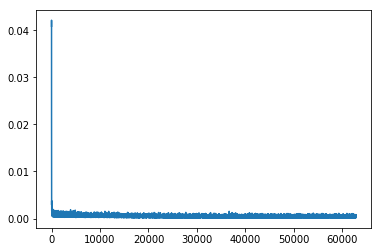

In [8]:
from matplotlib import pyplot as plt
plt.plot(loss_list)
plt.show()

In [9]:
# Guardamos el ultimo modelo
checkpoint_path_model = os.path.join('SINKP_NON_UCYZARA02_12_F', 'model.ckpt')
saver.save(sess,checkpoint_path_model , global_step = global_step)

'SINKP_NON_UCYZARA02_12_F/model.ckpt-62800'

# Restauramos los modelos

In [10]:
#Ultimo Modelo
path_model = 'SINKP_NON_UCYZARA02_12_F/model.ckpt-62800'
saver.restore(sess=sess, save_path=path_model)


test_data = batches_data.Dataset(data_prueba, arguments)
print('Evaluating')
results = evaluate(test_data, tester,sess,arguments)
print(results)

W0105 14:11:17.236983 139891789588224 deprecation.py:323] From /home/andrea/anaconda2/lib/python2.7/site-packages/tensorflow/python/training/saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.
  3%|2         | 8/296 [00:00<00:03, 73.63it/s]

Evaluating


100%|##########| 296/296 [00:03<00:00, 75.44it/s]


{'ade': 0.3308234, 'fde': 0.72537434}


In [11]:
#Modelo12
path_model = 'SINKP_NON_UCYZARA02_12/model.ckpt-62800'
saver.restore(sess=sess, save_path=path_model)


test_data = batches_data.Dataset(data_prueba, arguments)
print('Evaluating')
results = evaluate(test_data, tester,sess,arguments)
print(results)

  2%|1         | 5/296 [00:00<00:05, 48.72it/s]

Evaluating


100%|##########| 296/296 [00:03<00:00, 87.87it/s]


{'ade': 0.3308234, 'fde': 0.72537434}


In [12]:
# Mejor Modelo
path_model = 'SINKP_NON_UCYZARA02-BEST_12/model_best.ckpt-39300'
saver.restore(sess=sess, save_path=path_model)

test_data = batches_data.Dataset(data_prueba, arguments)
print('Evaluating')
results = evaluate(test_data, tester,sess,arguments)
print(results)

  1%|1         | 4/296 [00:00<00:07, 39.94it/s]

Evaluating


100%|##########| 296/296 [00:04<00:00, 69.99it/s]


{'ade': 0.33092174, 'fde': 0.7262849}
